In [1]:
options(warn=-1)
suppressMessages({library("dplyr")
library("tidyr")
library("reshape2")
library("readxl")
library("ggplot2")
library("RColorBrewer")
library("dendextend")
library("dendroextras")                  
library("GenomicRanges")
library("ranger")})

# CTCF motif orientation analysis

# <font size="3">General preliminary analysis<font>

In [2]:
# loading interactions
loops <-read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
loops$V7 <- 0
loops$V7[loops$V2>loops$V5] <- -((loops$V2[loops$V2>loops$V5]-loops$V6[loops$V2>loops$V5])/250+1)
loops$V7[loops$V2<loops$V5] <- (loops$V5[loops$V2<loops$V5]-loops$V3[loops$V2<loops$V5])/250+1
# selecting P-PIR interactions for downstrean analysis
baits <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/binned_peaks.bed", header = F, sep = "\t")[,c(1:3)]
bait_ranges <- GRanges(seqnames = baits$V1, ranges=IRanges(start=baits$V2, end=baits$V3, enh_id = seq(1,nrow(baits))))
loops_OE_ranges <- GRanges(seqnames = loops$V4, ranges=IRanges(start=loops$V5, end=loops$V6, enh_id = seq(1,nrow(loops))))
loops <- loops[-(as.data.frame(findOverlaps(loops_OE_ranges,bait_ranges))[,1]),]
# separating interactions with and without CTCF in promoter (CTCF is present PIR for both cases)
CTCF_peaks <- read.csv("Auxiliary_data//ENCFF002CEL.bed.gz", header = F, sep = "\t") # all peaks
CTCF_peaks_s <- filter(CTCF_peaks, V5 > 250) # sensa stricta peaks
CTCF_ranges_l <- GRanges(seqnames = CTCF_peaks$V1, ranges=IRanges(start=CTCF_peaks$V2, end=CTCF_peaks$V3, enh_id = seq(1,nrow(CTCF_peaks))))
CTCF_ranges_s <- GRanges(seqnames = CTCF_peaks_s$V1, ranges=IRanges(start=CTCF_peaks_s$V2, end=CTCF_peaks_s$V3, enh_id = seq(1,nrow(CTCF_peaks_s))))
PIR_ranges <- GRanges(seqnames = loops$V4, ranges=IRanges(start=loops$V5, end=loops$V6, enh_id = seq(1,nrow(loops))))
loops_PIR_CTCF <- loops[unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges_s))[,1]),]
loop_origin_ranges <- GRanges(seqnames = loops_PIR_CTCF$V1, ranges=IRanges(start=loops_PIR_CTCF$V2, end=loops_PIR_CTCF$V3, enh_id = seq(1,nrow(loops_PIR_CTCF))))
loops_PIR_only_CTCF <- loops_PIR_CTCF[-(unique(as.data.frame(findOverlaps(loop_origin_ranges,CTCF_ranges_l))[,1])),]
loops_PIR_and_bait_CTCF <- loops_PIR_CTCF[(unique(as.data.frame(findOverlaps(loop_origin_ranges,CTCF_ranges_l))[,1])),]
CTCF_peaks_in_baits <- CTCF_peaks[(unique(as.data.frame(findOverlaps(CTCF_ranges_l,loop_origin_ranges))[,1])),]
# compairing with loops identified in Rao et al., 2014 Hi-C
HiC_loops <- read.csv("Auxiliary_data//GSE63525_K562_HiCCUPS_looplist_with_motifs.txt.gz", header = T, sep = "\t")
HiC_loops <- filter(HiC_loops, !is.na(motif_x1) & !is.na(motif_x2))
HiC_loops$chr1 <- paste0("chr",HiC_loops$chr1)
HiC_loops$chr2 <- paste0("chr",HiC_loops$chr2)
HiC_loops_x_ranges <- GRanges(seqnames = HiC_loops$chr1, ranges=IRanges(start=HiC_loops$x1, end=HiC_loops$x2, enh_id = seq(1,nrow(HiC_loops))))
HiC_loops_y_ranges <- GRanges(seqnames = HiC_loops$chr2, ranges=IRanges(start=HiC_loops$y1, end=HiC_loops$y2, enh_id = seq(1,nrow(HiC_loops))))
CTCF_bait_ranges <- GRanges(seqnames = loops_PIR_and_bait_CTCF$V1, ranges=IRanges(start=loops_PIR_and_bait_CTCF$V2, end=loops_PIR_and_bait_CTCF$V3, enh_id = seq(1,nrow(loops_PIR_and_bait_CTCF))))
CTCF_PIR_ranges <- GRanges(seqnames = loops_PIR_and_bait_CTCF$V4, ranges=IRanges(start=loops_PIR_and_bait_CTCF$V5, end=loops_PIR_and_bait_CTCF$V6, enh_id = seq(1,nrow(loops_PIR_and_bait_CTCF))))
corresp <- left_join(unique(as.data.frame(findOverlaps(CTCF_bait_ranges,HiC_loops_x_ranges))), unique(as.data.frame(findOverlaps(CTCF_PIR_ranges,HiC_loops_y_ranges))), by="queryHits") %>% filter(subjectHits.x==subjectHits.y) %>%
bind_rows(left_join(unique(as.data.frame(findOverlaps(CTCF_bait_ranges,HiC_loops_y_ranges))), unique(as.data.frame(findOverlaps(CTCF_PIR_ranges,HiC_loops_x_ranges))), by="queryHits") %>% filter(subjectHits.x==subjectHits.y))
cat(paste0("We identified ", nrow(loops_PIR_CTCF), " interactions between promoters and individual CTCF-containing PIRs.\n",
           round(100*nrow(loops_PIR_and_bait_CTCF)/nrow(loops_PIR_CTCF),1),"% (", nrow(loops_PIR_and_bait_CTCF),
           ") of them showed CTCF ChIP-seq signal at the promoter side as well.\nOnly ", length(unique(corresp$queryHits)),
          " (", round(100*length(unique(corresp$queryHits))/nrow(loops_PIR_and_bait_CTCF)),
           "%) of those directly corresponded to CTCF-CTCF loops reported in a previous Hi-C study (Rao et al.,2014).\n", 
          nrow(loops_PIR_only_CTCF)," (", round(100*nrow(loops_PIR_only_CTCF)/nrow(loops_PIR_CTCF),1),
           "%) of P-(CTCF-bound PIR) interactions do not show CTCF-binding on the promoter side at all."))

We identified 38216 interactions between promoters and individual CTCF-containing PIRs.
51.6% (19732) of them showed CTCF ChIP-seq signal at the promoter side as well.
Only 539 (3%) of those directly corresponded to CTCF-CTCF loops reported in a previous Hi-C study (Rao et al.,2014).
18484 (48.4%) of P-(CTCF-bound PIR) interactions do not show CTCF-binding on the promoter side at all.

In [43]:
# searching for motifs in promoters and in PIRs
write.table(unique(loops_PIR_CTCF[,4:6]), file="tmp/PIRs_CTCF.bed", col.names = F, row.names = F, sep = "\t", quote = F)
write.table(unique(CTCF_peaks_in_baits[,1:3]), file="tmp/baits_CTCF.bed", col.names = F, row.names = F, sep = "\t", quote = F)
mot <- system("conda info | grep 'active env location' | cut -d ':' -f 2", intern=T)
mot <- substr(mot, 2, nchar(mot))
conf <- paste0(mot,"/share/homer/.//configureHomer.pl")
mot <- paste0(mot,"/share/homer/motifs/ctcf.motif")
system(paste0("perl ", conf, " -install hg19"), intern=T)
system(paste0("annotatePeaks.pl tmp/PIRs_CTCF.bed hg19 -nogene -noann -m ", mot," > tmp/motifs_in_PIRs_n"), intern=T)
system(paste0("annotatePeaks.pl tmp/baits_CTCF.bed hg19 -nogene -noann -m ", mot," > tmp/motifs_in_baits_n"), intern=T)

character(0)

character(0)

character(0)

In [3]:
# CTCF motifs in baits
loop_origins_with_CTCF <- read.csv("tmp/motifs_in_baits_n", header = T, sep = "\t")[c(2:4,10)]
colnames(loop_origins_with_CTCF)[4] <- "motif_orient"
loop_origins_with_CTCF <- unique(loop_origins_with_CTCF)
loop_origins_with_CTCF_a <- loop_origins_with_CTCF[!(grepl("\\-",loop_origins_with_CTCF$motif_orient) & grepl("\\+",loop_origins_with_CTCF$motif_orient) | loop_origins_with_CTCF$motif_orient %in% ""),]
loop_origins_with_CTCF_a$bait_CTCF_strand <- NA
for (i in seq(nrow(loop_origins_with_CTCF_a))){ if (grepl("\\+",loop_origins_with_CTCF_a[i,4])) {loop_origins_with_CTCF_a[i,5] <- "+"} else {loop_origins_with_CTCF_a[i,5] <- "-"}}
loop_origins_with_CTCF_b <- loop_origins_with_CTCF[grepl("\\-",loop_origins_with_CTCF$motif_orient) & grepl("\\+",loop_origins_with_CTCF$motif_orient),]
loop_origins_with_CTCF_b$bait_CTCF_strand <- "both"
loop_origins_with_CTCF <- bind_rows(loop_origins_with_CTCF_a[,c(1:3,5)],loop_origins_with_CTCF_b[,c(1:3,5)])
bait_ranges <- GRanges(seqnames = loop_origins_with_CTCF$Chr, ranges=IRanges(start=loop_origins_with_CTCF$Start, end=loop_origins_with_CTCF$End, enh_id = seq(1,nrow(loop_origins_with_CTCF))))
loop_origin_ranges <- GRanges(seqnames = loops_PIR_and_bait_CTCF$V1, ranges=IRanges(start=loops_PIR_and_bait_CTCF$V2, end=loops_PIR_and_bait_CTCF$V3, enh_id = seq(1,nrow(loops_PIR_and_bait_CTCF))))
loops_PIR_and_bait_CTCF$queryHits <- seq(1,nrow(loops_PIR_and_bait_CTCF))
loop_origins_with_CTCF$subjectHits <- seq(1,nrow(loop_origins_with_CTCF))
loops_PIR_and_bait_CTCF <- left_join(loops_PIR_and_bait_CTCF, as.data.frame(findOverlaps(loop_origin_ranges,bait_ranges)))
loops_PIR_and_bait_CTCF <- left_join(loops_PIR_and_bait_CTCF,loop_origins_with_CTCF[,c(4,5)])
# CTCF motifs in PIRs
loop_PIRs_with_CTCF <- read.csv("tmp/motifs_in_PIRs_n", header = T, sep = "\t")[c(2:4,10)]
colnames(loop_PIRs_with_CTCF)[4] <- "motif_orient"
loop_PIRs_with_CTCF <- unique(loop_PIRs_with_CTCF)
loop_PIRs_with_CTCF_a <- loop_PIRs_with_CTCF[!(grepl("\\-",loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",loop_PIRs_with_CTCF$motif_orient) | loop_PIRs_with_CTCF$motif_orient %in% ""),]
loop_PIRs_with_CTCF_a$PIR_CTCF_strand <- NA
for (i in seq(nrow(loop_PIRs_with_CTCF_a))){ if (grepl("\\+",loop_PIRs_with_CTCF_a[i,4])) {loop_PIRs_with_CTCF_a[i,5] <- "+"} else {loop_PIRs_with_CTCF_a[i,5] <- "-"}}
loop_PIRs_with_CTCF_b <- loop_PIRs_with_CTCF[grepl("\\-",loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",loop_PIRs_with_CTCF$motif_orient),]
loop_PIRs_with_CTCF_b$PIR_CTCF_strand <- "both"
loop_PIRs_with_CTCF <- bind_rows(loop_PIRs_with_CTCF_a[,c(1:3,5)],loop_PIRs_with_CTCF_b[,c(1:3,5)])
loops_PIR_and_bait_CTCF <- left_join(loops_PIR_and_bait_CTCF, loop_PIRs_with_CTCF[,c(1,3,4)], by=c('V4'='Chr', 'V6'='End'))
loops_PIR_only_CTCF <- left_join(loops_PIR_only_CTCF, loop_PIRs_with_CTCF[,c(1,3,4)], by=c('V4'='Chr', 'V6'='End'))
# baits transcription directionality
baits <- read.csv("MChIPC_output/MChIPC_viewpoints.bed", header = F, sep = "\t")[1:3]
TSS <- read.csv("Auxiliary_data//RefSeqCurated.170308.bed.CollapsedGeneBounds.TSS.500bp.bed", sep = "\t", header = F)[c(1:4,6)]
bait_ranges <- GRanges(seqnames = baits$V1, ranges=IRanges(start=baits$V2, end=baits$V3))
TSS_ranges <- GRanges(seqnames = TSS$V1, ranges=IRanges(start=TSS$V2, end=TSS$V3))
overlaps <- as.data.frame(findOverlaps(bait_ranges,TSS_ranges)) %>% group_by(queryHits) %>% summarise(number = n(), subjectHits) %>% filter(number==1)
baits$queryHits <- seq(nrow(baits))
TSS$subjectHits <- seq(nrow(TSS))
baits <- left_join(baits, overlaps) %>% left_join(TSS, by="subjectHits") %>% filter(!(is.na(number)))
baits <- baits[c(1:3,11)]
colnames(baits) <- c("V1","V2","V3","transcription_dir")

Joining, by = "queryHits"
Joining, by = "subjectHits"
`summarise()` has grouped output by 'queryHits'. You can override using the `.groups` argument.
Joining, by = "queryHits"


# <font size="3">Analysis of interactions in which CTCF is bound to PIR only<font>

In [4]:
loops_PIR_only_CTCF <- left_join(loops_PIR_only_CTCF, baits)
cat(paste0("Not considering direcctionality of transcription there are ",
    nrow(filter(loops_PIR_only_CTCF, (V7<0&PIR_CTCF_strand=="-" | V7>0&PIR_CTCF_strand=="+" ))), " (",
    round(100*nrow(filter(loops_PIR_only_CTCF, (V7<0&PIR_CTCF_strand=="-" | V7>0&PIR_CTCF_strand=="+" )))/nrow(filter(loops_PIR_only_CTCF,PIR_CTCF_strand%in%c("+","-"))), 1),
    "%) cases\nin which CTCF motif in PIR is oriented towards its promoter-partner not bound by CTCF.
Correspondingly there are only ", nrow(filter(loops_PIR_only_CTCF, (V7<0&PIR_CTCF_strand=="+" | V7>0&PIR_CTCF_strand=="-" ))),
    " (", round(100*nrow(filter(loops_PIR_only_CTCF, (V7<0&PIR_CTCF_strand=="+" | V7>0&PIR_CTCF_strand=="-" )))/nrow(filter(loops_PIR_only_CTCF,PIR_CTCF_strand%in%c("+","-"))), 1),       
    "%) opposite cases\nin which CTCF motif in PIR is oriented away of its promoter-partner not bound by CTCF."))
loops_PIR_only_CTCF <- filter(loops_PIR_only_CTCF, !(is.na(transcription_dir)))
loops_PIR_only_CTCF_flipped <- loops_PIR_only_CTCF
loops_PIR_only_CTCF_flipped['V7'][loops_PIR_only_CTCF_flipped['transcription_dir']=="-"] <- -1*loops_PIR_only_CTCF_flipped['V7'][loops_PIR_only_CTCF_flipped['transcription_dir']=="-"]
loops_PIR_only_CTCF_flipped['PIR_CTCF_strand'][loops_PIR_only_CTCF_flipped['transcription_dir']=="-" & loops_PIR_only_CTCF_flipped['PIR_CTCF_strand']=="+"] <- 0
loops_PIR_only_CTCF_flipped['PIR_CTCF_strand'][loops_PIR_only_CTCF_flipped['transcription_dir']=="-" & loops_PIR_only_CTCF_flipped['PIR_CTCF_strand']=="-"] <- "+"
loops_PIR_only_CTCF_flipped['PIR_CTCF_strand'][loops_PIR_only_CTCF_flipped['transcription_dir']=="-" & loops_PIR_only_CTCF_flipped['PIR_CTCF_strand']==0] <- "-"
cat(paste0("\nIf we then consider directionality of transcription from each promoter\nwe can analyze separately CTCF sites upstream and downstream of promoters.
For upstream CTCF sites we have ", nrow(filter(loops_PIR_only_CTCF_flipped, V7<0 & PIR_CTCF_strand=="-")),
" (", round(100*nrow(filter(loops_PIR_only_CTCF_flipped, V7<0 & PIR_CTCF_strand=="-"))/nrow(filter(loops_PIR_only_CTCF_flipped, V7<0 & PIR_CTCF_strand%in%c("+","-"))),1),
"%) cases\nin which CTCF motif in PIR is oriented towards its promoter-partner not bound by CTCF,\nand ",
nrow(filter(loops_PIR_only_CTCF_flipped, V7<0 & PIR_CTCF_strand=="+")),
" (", round(100*nrow(filter(loops_PIR_only_CTCF_flipped, V7<0 & PIR_CTCF_strand=="+"))/nrow(filter(loops_PIR_only_CTCF_flipped, V7<0 & PIR_CTCF_strand%in%c("+","-"))),1),
"%) cases in which CTCF motif in PIR is oriented away.\n",
"For downstream CTCF sites we have ", nrow(filter(loops_PIR_only_CTCF_flipped, V7>0 & PIR_CTCF_strand=="+")),
" (", round(100*nrow(filter(loops_PIR_only_CTCF_flipped, V7>0 & PIR_CTCF_strand=="+"))/nrow(filter(loops_PIR_only_CTCF_flipped, V7>0 & PIR_CTCF_strand%in%c("+","-"))),1),
"%) cases\nin which CTCF motif in PIR is oriented towards its promoter-partner not bound by CTCF,\nand ",
nrow(filter(loops_PIR_only_CTCF_flipped, V7>0 & PIR_CTCF_strand=="-")),
" (", round(100*nrow(filter(loops_PIR_only_CTCF_flipped, V7>0 & PIR_CTCF_strand=="-"))/nrow(filter(loops_PIR_only_CTCF_flipped, V7>0 & PIR_CTCF_strand%in%c("+","-"))),1),
"%) cases in which CTCF motif in PIR is oriented away."))

Joining, by = c("V1", "V2", "V3")


Not considering direcctionality of transcription there are 6844 (79.5%) cases
in which CTCF motif in PIR is oriented towards its promoter-partner not bound by CTCF.
Correspondingly there are only 1768 (20.5%) opposite cases
in which CTCF motif in PIR is oriented away of its promoter-partner not bound by CTCF.
If we then consider directionality of transcription from each promoter
we can analyze separately CTCF sites upstream and downstream of promoters.
For upstream CTCF sites we have 2457 (79.6%) cases
in which CTCF motif in PIR is oriented towards its promoter-partner not bound by CTCF,
and 630 (20.4%) cases in which CTCF motif in PIR is oriented away.
For downstream CTCF sites we have 2225 (79%) cases
in which CTCF motif in PIR is oriented towards its promoter-partner not bound by CTCF,
and 590 (21%) cases in which CTCF motif in PIR is oriented away.

In [153]:
# building background randomized model (for CTCF in PIR-only P-PIRs)
# performing 100 interaction randomization cycles
loops <-read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
loops$V7 <- 0
loops$V7[loops$V2>loops$V5] <- -((loops$V2[loops$V2>loops$V5]-loops$V6[loops$V2>loops$V5])/250+1)
loops$V7[loops$V2<loops$V5] <- (loops$V5[loops$V2<loops$V5]-loops$V3[loops$V2<loops$V5])/250+1
loop_origin_ranges <- GRanges(seqnames = loops$V1, ranges=IRanges(start=loops$V2, end=loops$V3, enh_id = seq(1,nrow(loops))))
loops_promoter_wo_CTCF <- loops[-(unique(as.data.frame(findOverlaps(loop_origin_ranges,CTCF_ranges_l))[,1])),]
loops_promoter_wo_CTCF <- left_join(loops_promoter_wo_CTCF, baits)
loops_promoter_wo_CTCF <- filter(loops_promoter_wo_CTCF, !(is.na(transcription_dir)))
loop_OE_ranges <- GRanges(seqnames = loops_promoter_wo_CTCF$V4, ranges=IRanges(start=loops_promoter_wo_CTCF$V5, end=loops_promoter_wo_CTCF$V6, enh_id = seq(1,nrow(loops_promoter_wo_CTCF))))
target_n <- nrow(loops_promoter_wo_CTCF[-(unique(as.data.frame(findOverlaps(loop_OE_ranges,bait_ranges))[,1])),])

set.seed(42)

randomized_loops <- data.frame()
for (i in seq(100)){
  randomized_OE <- loops_promoter_wo_CTCF[,c(1:6,8)]
  randomized_OE$V7 <- sample(loops_promoter_wo_CTCF$V7)
  randomized_pos <- filter(randomized_OE, V7 > 0)
  randomized_neg <- filter(randomized_OE, V7 < 0)
  randomized_pos$V6 <- randomized_pos$V3 + randomized_pos$V7 * 250
  randomized_pos$V5 <- randomized_pos$V6 - 250
  randomized_neg$V5 <- randomized_neg$V2 + randomized_neg$V7 *250
  randomized_neg$V6 <- randomized_neg$V5 + 250
  randomized_OE <- bind_rows(randomized_pos, randomized_neg)
  PIR_randomized_ranges <- GRanges(seqnames = randomized_OE$V4, ranges=IRanges(start=randomized_OE$V5, end=randomized_OE$V6, enh_id = seq(1,nrow(randomized_OE))))
  randomized_OE <- sample_n(randomized_OE[-unique(as.data.frame(findOverlaps(PIR_randomized_ranges,bait_ranges))[,1]),], target_n)
  randomized_loops <- rbind(randomized_loops, randomized_OE)}
PIR_ranges <- GRanges(seqnames = randomized_loops$V4, ranges=IRanges(start=randomized_loops$V5, end=randomized_loops$V6, enh_id = seq(1,nrow(randomized_loops))))
randomized_loops_PIR_CTCF <- randomized_loops[unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges_s))[,1]),][,c(1:6,8,7)]  
colnames(randomized_loops_PIR_CTCF)[8] <- 'transcription_dir'
write.table(unique(randomized_loops_PIR_CTCF[,4:6]), file="tmp/rand_PIRs_CTCF.bed", col.names = F, row.names = F, sep = "\t", quote = F)

# using Homer 'annotatePeaks.pl' to find motifs
system(paste0("annotatePeaks.pl tmp/rand_PIRs_CTCF.bed hg19 -nogene -noann -m ", mot," > tmp/motifs_in_rand_PIRs_n"), intern=T)

rand_loop_PIRs_with_CTCF <- read.csv("tmp/motifs_in_rand_PIRs_n", header = T, sep = "\t")[c(2:4,10)]
colnames(rand_loop_PIRs_with_CTCF)[4] <- "motif_orient"
rand_loop_PIRs_with_CTCF <- unique(rand_loop_PIRs_with_CTCF)
rand_loop_PIRs_with_CTCF_a <- rand_loop_PIRs_with_CTCF[!(grepl("\\-",rand_loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",rand_loop_PIRs_with_CTCF$motif_orient) | rand_loop_PIRs_with_CTCF$motif_orient %in% ""),]
rand_loop_PIRs_with_CTCF_a$PIR_CTCF_strand <- NA
for (i in seq(nrow(rand_loop_PIRs_with_CTCF_a))){ if (grepl("\\+",rand_loop_PIRs_with_CTCF_a[i,4])) {rand_loop_PIRs_with_CTCF_a[i,5] <- "+"} else {rand_loop_PIRs_with_CTCF_a[i,5] <- "-"}}
rand_loop_PIRs_with_CTCF_b <- rand_loop_PIRs_with_CTCF[grepl("\\-",rand_loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",rand_loop_PIRs_with_CTCF$motif_orient),]
rand_loop_PIRs_with_CTCF_b$PIR_CTCF_strand <- "both"
rand_loop_PIRs_with_CTCF <- bind_rows(rand_loop_PIRs_with_CTCF_a[,c(1:3,5)],rand_loop_PIRs_with_CTCF_b[,c(1:3,5)])
# adding info about CTCF motifs to random loops
randomized_loops_PIR_CTCF <- left_join(randomized_loops_PIR_CTCF, rand_loop_PIRs_with_CTCF[,c(1,3,4)], by=c('V4'='Chr', 'V6'='End'))
# plotting random loops of CTCF-less promoters
# flipping CTCF position such as all transcription in the same direction
randomized_loops_PIR_CTCF_flipped <- randomized_loops_PIR_CTCF
randomized_loops_PIR_CTCF_flipped['V7'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-"] <- -1*randomized_loops_PIR_CTCF_flipped['V7'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-"]
randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-" & randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand']=="+"] <- 0
randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-" & randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand']=="-"] <- "+"
randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-" & randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand']==0] <- "-"
randomized_loops_PIR_CTCF_flipped <- arrange(filter(randomized_loops_PIR_CTCF_flipped, (PIR_CTCF_strand %in% c("-","+"))&(abs(V7)<=2000)), V7)
randomized_loops_PIR_CTCF_flipped <- randomized_loops_PIR_CTCF_flipped %>% mutate(bin = cut(c(-2000,V7,2000), breaks=100)[2:(length(V7)+1)])
randomized_loops_PIR_CTCF_flipped_m <- filter(randomized_loops_PIR_CTCF_flipped, PIR_CTCF_strand=="-")
randomized_loops_PIR_CTCF_flipped_p <- filter(randomized_loops_PIR_CTCF_flipped, PIR_CTCF_strand=="+")
randomized_loops_PIR_CTCF_flipped_m <- left_join(randomized_loops_PIR_CTCF_flipped_m, randomized_loops_PIR_CTCF_flipped_m %>% group_by(bin) %>% summarise(sum=length(V7)/100))
randomized_loops_PIR_CTCF_flipped_p <- left_join(randomized_loops_PIR_CTCF_flipped_p, randomized_loops_PIR_CTCF_flipped_p %>% group_by(bin) %>% summarise(sum=length(V7)/100))
stat_m <- data.frame(bin=unique(cut(seq(-2000,2000),100)), coord=seq(-1980,1980,40))
stat_m <- left_join(stat_m, distinct(randomized_loops_PIR_CTCF_flipped_m[,c(10,11)]))
stat_m$sum[is.na(stat_m$sum)] <- 0
stat_p <- left_join(stat_m[,c(1,2)], distinct(randomized_loops_PIR_CTCF_flipped_p[,c(10,11)]))
stat_p$sum[is.na(stat_p$sum)] <- 0

Joining, by = c("V1", "V2", "V3")


character(0)

Joining, by = "bin"
Joining, by = "bin"
Joining, by = "bin"
Joining, by = "bin"


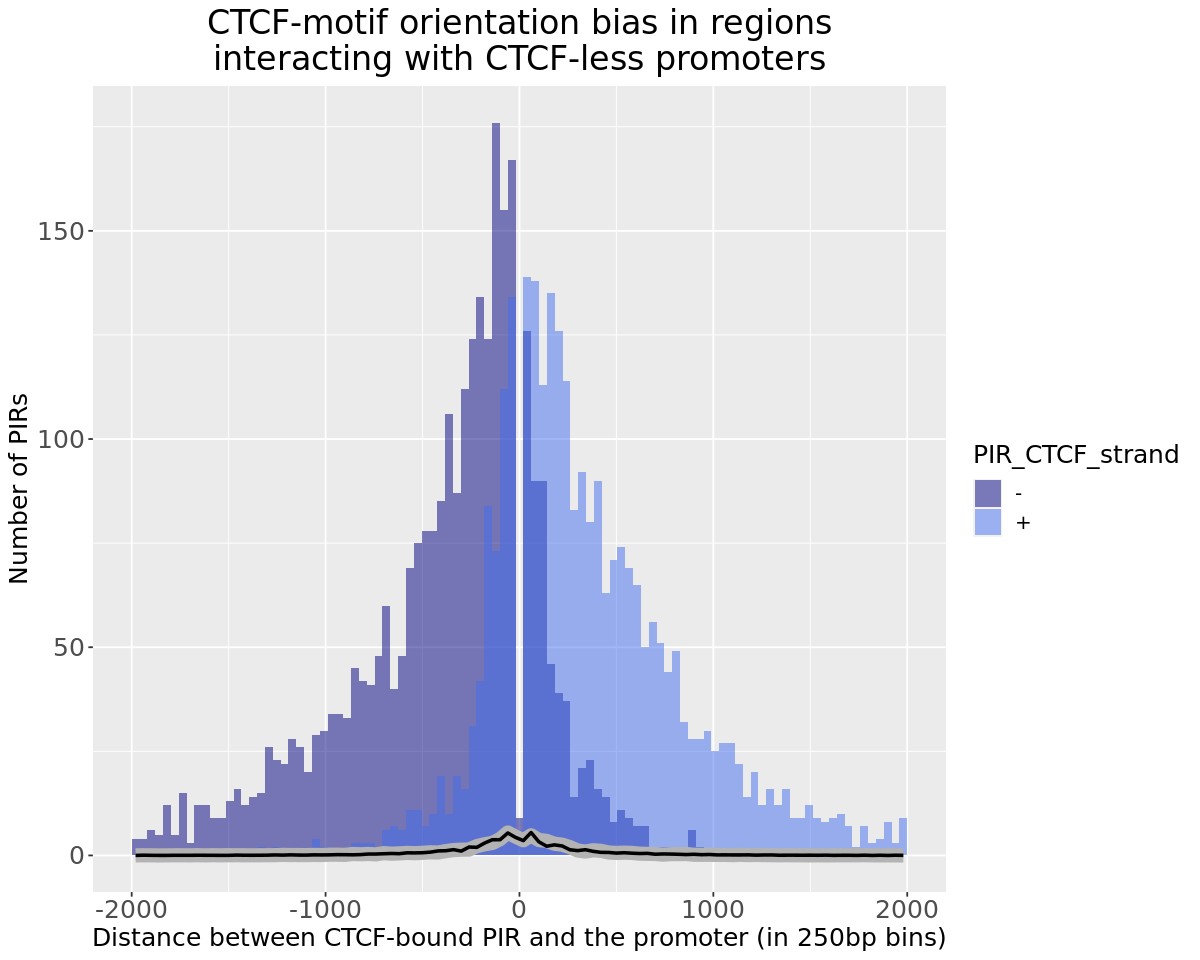

In [141]:
data_h <- filter(loops_PIR_only_CTCF_flipped, PIR_CTCF_strand %in% c("-","+"))
options(repr.plot.width=10, repr.plot.height=8)
ggplot() + geom_histogram(data=data_h, aes(data_h$V7, fill=PIR_CTCF_strand),alpha=0.5, bins = 100, position="identity") + 
scale_fill_manual(values=c("navyblue","royalblue2"))+
xlim(-2000,2000)+ geom_line(aes(stat_m$coord, stat_m$sum), color="grey70", size=4) + geom_line(aes(stat_p$coord, stat_p$sum), size=1)+
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=15),
     plot.title=element_text(size=20, hjust=0.5)) + labs(y="Number of PIRs",x="Distance between CTCF-bound PIR and the promoter (in 250bp bins)")+
ggtitle("CTCF-motif orientation bias in regions\ninteracting with CTCF-less promoters")
ggsave("Figures/Fig.3/3a_CTCF_motif_orientation_bias_no_CTCF_binding.pdf",device="pdf",width=10, height=8)

# <font size="3">Analysis of interactions in which CTCF is bound to both promoter and PIR and there is no CTCF motif in promoter<font>

In [163]:
loops_PIR_motif <- filter(loops_PIR_and_bait_CTCF, is.na(bait_CTCF_strand) & !(is.na(PIR_CTCF_strand)) & (PIR_CTCF_strand=="-" | PIR_CTCF_strand=="+" ))
loops_PIR_motif <- left_join(loops_PIR_motif, baits)
loops_PIR_motif <- filter(loops_PIR_motif, !(is.na(transcription_dir)))
loops_PIR_motif_flipped <- loops_PIR_motif
loops_PIR_motif_flipped['V7'][loops_PIR_motif_flipped['transcription_dir']=="-"] <- -1*loops_PIR_motif_flipped['V7'][loops_PIR_motif_flipped['transcription_dir']=="-"]
loops_PIR_motif_flipped['PIR_CTCF_strand'][loops_PIR_motif_flipped['transcription_dir']=="-" & loops_PIR_motif_flipped['PIR_CTCF_strand']=="+"] <- 0
loops_PIR_motif_flipped['PIR_CTCF_strand'][loops_PIR_motif_flipped['transcription_dir']=="-" & loops_PIR_motif_flipped['PIR_CTCF_strand']=="-"] <- "+"
loops_PIR_motif_flipped['PIR_CTCF_strand'][loops_PIR_motif_flipped['transcription_dir']=="-" & loops_PIR_motif_flipped['PIR_CTCF_strand']==0] <- "-"
cat(paste0("Not considering direcctionality of transcription there are ",
nrow(filter(loops_PIR_and_bait_CTCF, is.na(bait_CTCF_strand)&(V7<0&PIR_CTCF_strand=="-"|V7>0&PIR_CTCF_strand=="+"))),
" (", round(100*nrow(filter(loops_PIR_and_bait_CTCF, is.na(bait_CTCF_strand)&(V7<0&PIR_CTCF_strand=="-"|V7>0&PIR_CTCF_strand=="+")))/nrow(filter(loops_PIR_and_bait_CTCF,is.na(bait_CTCF_strand)&PIR_CTCF_strand%in%c("+","-"))), 1),
    "%) cases in which CTCF motif in PIR\nis oriented towards its promoter-partner bound by CTCF (but lacking CTCF motif).
Correspondingly there are only ", nrow(filter(loops_PIR_and_bait_CTCF, is.na(bait_CTCF_strand)&(V7>0&PIR_CTCF_strand=="-"|V7<0&PIR_CTCF_strand=="+"))),
    " (", round(100*nrow(filter(loops_PIR_and_bait_CTCF, is.na(bait_CTCF_strand)&(V7>0&PIR_CTCF_strand=="-"|V7<0&PIR_CTCF_strand=="+")))/nrow(filter(loops_PIR_and_bait_CTCF,is.na(bait_CTCF_strand)&PIR_CTCF_strand%in%c("+","-"))), 1),       
    "%) opposite cases in which CTCF motif in PIR\nis oriented away of its promoter-partner bound by CTCF (but lacking CTCF motif)."))

Joining, by = c("V1", "V2", "V3")


Not considering direcctionality of transcription there are 5000 (79.6%) cases in which CTCF motif in PIR
is oriented towards its promoter-partner bound by CTCF (but lacking CTCF motif).
Correspondingly there are only 1281 (20.4%) opposite cases in which CTCF motif in PIR
is oriented away of its promoter-partner bound by CTCF (but lacking CTCF motif).

In [164]:
# building background randomized model (for CTCF in both PIR and promoter, with no motif in promoter)
# performing 100 interaction randomization cycles
loops_promoter_w_CTCF <- loops[unique(as.data.frame(findOverlaps(loop_origin_ranges,CTCF_ranges_l))[,1]),]
loops_promoter_w_CTCF$queryHits <- seq(1,nrow(loops_promoter_w_CTCF))
loops_promoter_w_CTCF <- left_join(loops_promoter_w_CTCF, as.data.frame(findOverlaps(loop_origin_ranges,bait_ranges)))
loops_promoter_w_CTCF <- left_join(loops_promoter_w_CTCF,loop_origins_with_CTCF[,c(4,5)])
loops_promoter_w_CTCF <- filter(loops_promoter_w_CTCF, is.na(bait_CTCF_strand))
# filtering out promoters with ambigous directionality
loops_promoter_w_CTCF <- left_join(loops_promoter_w_CTCF, baits)
loops_promoter_w_CTCF <- filter(loops_promoter_w_CTCF, !(is.na(transcription_dir)))
# calculating expected number of promoter_w_CTCF - PIR loops
loop_OE_ranges <- GRanges(seqnames = loops_promoter_w_CTCF$V4, ranges=IRanges(start=loops_promoter_w_CTCF$V5, end=loops_promoter_w_CTCF$V6, enh_id = seq(1,nrow(loops_promoter_w_CTCF))))
bait_ranges <- GRanges(seqnames = baits$V1, ranges=IRanges(start=baits$V2, end=baits$V3, enh_id = seq(1,nrow(baits))))
target_n <- nrow(loops_promoter_w_CTCF[-(unique(as.data.frame(findOverlaps(loop_OE_ranges,bait_ranges))[,1])),])

set.seed(42)
randomized_loops <- data.frame()
for (i in seq(100)){
  randomized_OE <- loops_promoter_w_CTCF[,c(1:6,11)]
  randomized_OE$V7 <- sample(loops_promoter_w_CTCF$V7)
  randomized_pos <- filter(randomized_OE, V7 > 0)
  randomized_neg <- filter(randomized_OE, V7 < 0)
  randomized_pos$V6 <- randomized_pos$V3 + randomized_pos$V7 * 250
  randomized_pos$V5 <- randomized_pos$V6 - 250
  randomized_neg$V5 <- randomized_neg$V2 + randomized_neg$V7 *250
  randomized_neg$V6 <- randomized_neg$V5 + 250
  randomized_OE <- bind_rows(randomized_pos, randomized_neg)
  PIR_randomized_ranges <- GRanges(seqnames = randomized_OE$V4, ranges=IRanges(start=randomized_OE$V5, end=randomized_OE$V6, enh_id = seq(1,nrow(randomized_OE))))
  randomized_OE <- sample_n(randomized_OE[-unique(as.data.frame(findOverlaps(PIR_randomized_ranges,bait_ranges))[,1]),], target_n)
  randomized_loops <- rbind(randomized_loops, randomized_OE)}
PIR_ranges <- GRanges(seqnames = randomized_loops$V4, ranges=IRanges(start=randomized_loops$V5, end=randomized_loops$V6, enh_id = seq(1,nrow(randomized_loops))))
randomized_loops_PIR_CTCF <- randomized_loops[unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges_s))[,1]),][,c(1:6,8,7)]
colnames(randomized_loops_PIR_CTCF)[8] <- 'transcription_dir'
write.table(unique(randomized_loops_PIR_CTCF[,4:6]), file="tmp/rand_bait_CTCF.bed", col.names = F, row.names = F, sep = "\t", quote = F)

# using Homer 'annotatePeaks.pl' to find CTCF-motifs
system(paste0("annotatePeaks.pl tmp/rand_PIRs_CTCF.bed hg19 -nogene -noann -m ", mot," > tmp/motifs_in_rand_PIRs_bait_CTCF_n"), intern=T)

rand_loop_PIRs_with_CTCF <- read.csv("tmp/motifs_in_rand_PIRs_bait_CTCF_n", header = T, sep = "\t")[c(2:4,10)]
colnames(rand_loop_PIRs_with_CTCF)[4] <- "motif_orient"
rand_loop_PIRs_with_CTCF <- unique(rand_loop_PIRs_with_CTCF)
rand_loop_PIRs_with_CTCF_a <- rand_loop_PIRs_with_CTCF[!(grepl("\\-",rand_loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",rand_loop_PIRs_with_CTCF$motif_orient) | rand_loop_PIRs_with_CTCF$motif_orient %in% ""),]
rand_loop_PIRs_with_CTCF_a$PIR_CTCF_strand <- NA
for (i in seq(nrow(rand_loop_PIRs_with_CTCF_a))){ if (grepl("\\+",rand_loop_PIRs_with_CTCF_a[i,4])) {rand_loop_PIRs_with_CTCF_a[i,5] <- "+"} else {rand_loop_PIRs_with_CTCF_a[i,5] <- "-"}}
rand_loop_PIRs_with_CTCF_b <- rand_loop_PIRs_with_CTCF[grepl("\\-",rand_loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",rand_loop_PIRs_with_CTCF$motif_orient),]
rand_loop_PIRs_with_CTCF_b$PIR_CTCF_strand <- "both"
rand_loop_PIRs_with_CTCF <- bind_rows(rand_loop_PIRs_with_CTCF_a[,c(1:3,5)],rand_loop_PIRs_with_CTCF_b[,c(1:3,5)])
# adding info about CTCF motifs to random loops
randomized_loops_PIR_CTCF <- left_join(randomized_loops_PIR_CTCF, rand_loop_PIRs_with_CTCF[,c(1,3,4)], by=c('V4'='Chr', 'V6'='End'))
# plotting random loops of CTCF-bound promoters (without motif)
# flipping CTCF position such as all transcription in the same direction
randomized_loops_PIR_CTCF_flipped <- randomized_loops_PIR_CTCF
randomized_loops_PIR_CTCF_flipped['V7'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-"] <- -1*randomized_loops_PIR_CTCF_flipped['V7'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-"]
randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-" & randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand']=="+"] <- 0
randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-" & randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand']=="-"] <- "+"
randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand'][randomized_loops_PIR_CTCF_flipped['transcription_dir']=="-" & randomized_loops_PIR_CTCF_flipped['PIR_CTCF_strand']==0] <- "-"
randomized_loops_PIR_CTCF_flipped <- arrange(filter(randomized_loops_PIR_CTCF_flipped, (PIR_CTCF_strand %in% c("-","+"))&(abs(V7)<=2000)), V7)
randomized_loops_PIR_CTCF_flipped <- randomized_loops_PIR_CTCF_flipped %>% mutate(bin = cut(c(-2000,V7,2000), breaks=100)[2:(length(V7)+1)])
randomized_loops_PIR_CTCF_flipped_m <- filter(randomized_loops_PIR_CTCF_flipped, PIR_CTCF_strand=="-")
randomized_loops_PIR_CTCF_flipped_p <- filter(randomized_loops_PIR_CTCF_flipped, PIR_CTCF_strand=="+")
randomized_loops_PIR_CTCF_flipped_m <- left_join(randomized_loops_PIR_CTCF_flipped_m, randomized_loops_PIR_CTCF_flipped_m %>% group_by(bin) %>% summarise(sum=length(V7)/100))
randomized_loops_PIR_CTCF_flipped_p <- left_join(randomized_loops_PIR_CTCF_flipped_p, randomized_loops_PIR_CTCF_flipped_p %>% group_by(bin) %>% summarise(sum=length(V7)/100))
stat_m <- data.frame(bin=unique(cut(seq(-2000,2000),100)), coord=seq(-1980,1980,40))
stat_m <- left_join(stat_m, distinct(randomized_loops_PIR_CTCF_flipped_m[,c(10,11)]))
stat_m$sum[is.na(stat_m$sum)] <- 0
stat_p <- left_join(stat_m[,c(1,2)], distinct(randomized_loops_PIR_CTCF_flipped_p[,c(10,11)]))
stat_p$sum[is.na(stat_p$sum)] <- 0

Joining, by = "queryHits"
Joining, by = "subjectHits"
Joining, by = c("V1", "V2", "V3")


character(0)

Joining, by = "bin"
Joining, by = "bin"
Joining, by = "bin"
Joining, by = "bin"


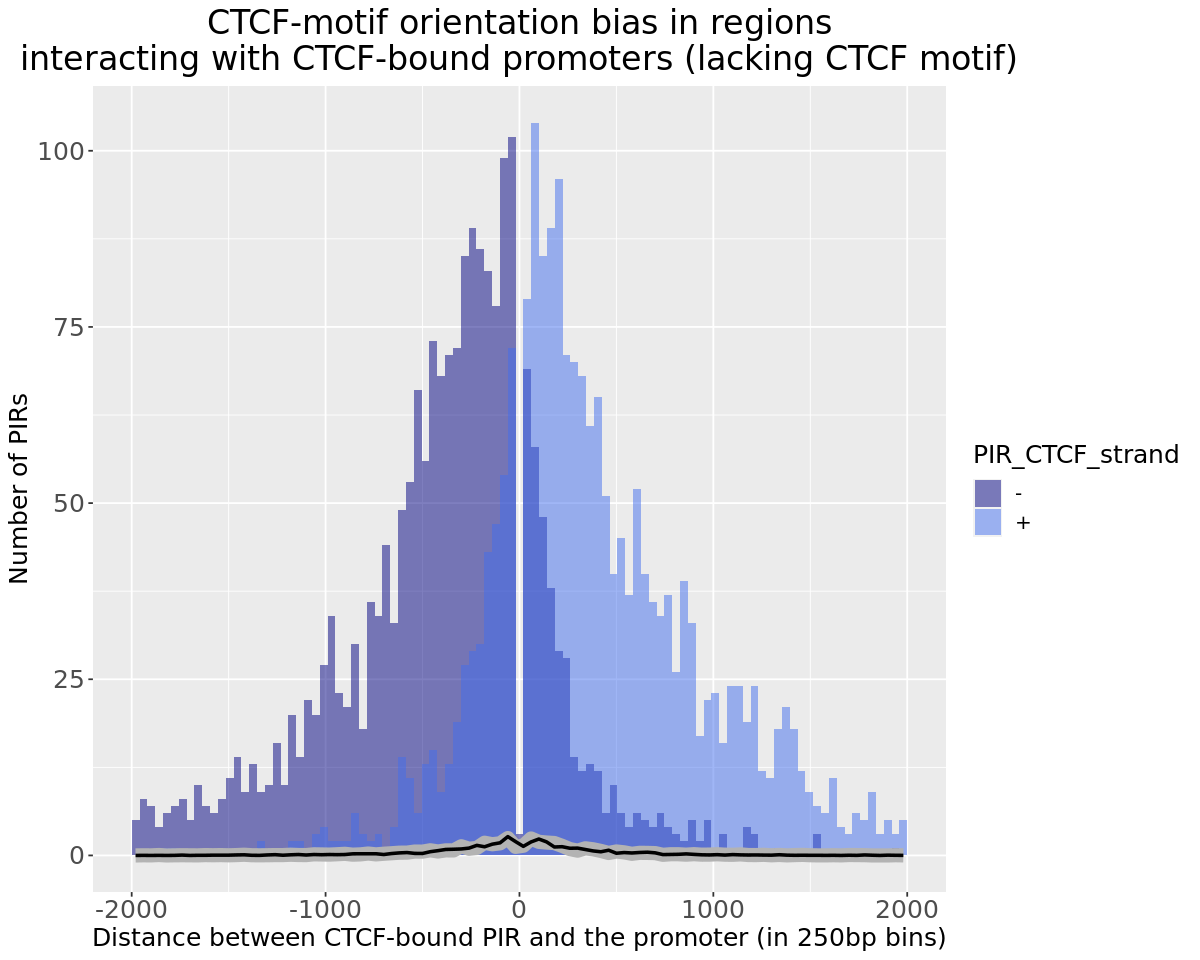

In [166]:
data_h <- filter(loops_PIR_motif_flipped, PIR_CTCF_strand %in% c("-","+"))
options(repr.plot.width=10, repr.plot.height=8)
ggplot() + geom_histogram(data=data_h, aes(data_h$V7, fill=PIR_CTCF_strand),alpha=0.5, bins = 100, position="identity") + 
scale_fill_manual(values=c("navyblue","royalblue2"))+
xlim(-2000,2000)+ geom_line(aes(stat_m$coord, stat_m$sum), color="grey70", size=4) + geom_line(aes(stat_p$coord, stat_p$sum), size=1)+
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=15),
     plot.title=element_text(size=20, hjust=0.5)) + labs(y="Number of PIRs",x="Distance between CTCF-bound PIR and the promoter (in 250bp bins)")+
ggtitle("CTCF-motif orientation bias in regions\ninteracting with CTCF-bound promoters (lacking CTCF motif)")
ggsave("Figures/Fig.S4/S4a_CTCF_motif_orientation_bias_CTCF_bound_promoters.pdf",device="pdf",width=10, height=8)

# <font size="3">Analysis of interactions in which CTCF is bound to both promoter and PIR and CTCF motif is present in the promoter<font>

In [181]:
loops_PIR_and_bait_motifs <- filter(loops_PIR_and_bait_CTCF, queryHits %in% (filter(loops_PIR_and_bait_CTCF, !(is.na(bait_CTCF_strand)) & !(is.na(PIR_CTCF_strand))) %>% group_by(queryHits) %>% summarise(N=length(unique(bait_CTCF_strand))) %>% filter(N==1))$queryHits & bait_CTCF_strand != "both" & PIR_CTCF_strand != "both")
loops_PIR_and_bait_motifs <- unique(loops_PIR_and_bait_motifs[,-9])
loops_PIR_and_bait_motifs_flipped <- loops_PIR_and_bait_motifs
loops_PIR_and_bait_motifs_flipped$PIR_CTCF_strand_flipped <- loops_PIR_and_bait_motifs_flipped$PIR_CTCF_strand
loops_PIR_and_bait_motifs_flipped$PIR_CTCF_strand_flipped[loops_PIR_and_bait_motifs_flipped$bait_CTCF_strand == "+" & loops_PIR_and_bait_motifs_flipped$PIR_CTCF_strand == "-"] <- "+"
loops_PIR_and_bait_motifs_flipped$PIR_CTCF_strand_flipped[loops_PIR_and_bait_motifs_flipped$bait_CTCF_strand == "+" & loops_PIR_and_bait_motifs_flipped$PIR_CTCF_strand == "+"] <- "-"
loops_PIR_and_bait_motifs_flipped['V7'][loops_PIR_and_bait_motifs_flipped['bait_CTCF_strand']=="+"] <- -1*loops_PIR_and_bait_motifs_flipped['V7'][loops_PIR_and_bait_motifs_flipped['bait_CTCF_strand']=="+"]
convergent <- nrow(filter(loops_PIR_and_bait_motifs,
(bait_CTCF_strand=="+"& PIR_CTCF_strand=="-"&V7<0)|(bait_CTCF_strand=="-"&PIR_CTCF_strand=="+"&V7>0)))
divergent <- nrow(filter(loops_PIR_and_bait_motifs,
(bait_CTCF_strand=="+"&PIR_CTCF_strand=="-"&V7>0)|(bait_CTCF_strand=="-"& PIR_CTCF_strand=="+"&V7<0)))
colinear_tow <- nrow(filter(loops_PIR_and_bait_motifs, 
(bait_CTCF_strand=="-"&PIR_CTCF_strand=="-"&V7<0)|(bait_CTCF_strand=="+"& PIR_CTCF_strand=="+"&V7>0)))
colinear_away <- nrow(filter(loops_PIR_and_bait_motifs, 
(bait_CTCF_strand=="-"& PIR_CTCF_strand=="-"&V7> 0)|(bait_CTCF_strand=="+"& PIR_CTCF_strand=="+"&V7<0)))
cat(paste0("Not considering direcctionality of transcription we identified ",
    convergent, " (", round(100*convergent/nrow(loops_PIR_and_bait_motifs), 1),
    "%) cases\nin which a pair of CTCF motifs in PIR and interacting promoter are oriented convergently.
There are only ", divergent," (", round(100*divergent/nrow(loops_PIR_and_bait_motifs), 1),       
    "%) cases in which a pair of CTCF motifs in PIR and promoter are oriented divergently.\n",
colinear_tow, " (", round(100*colinear_tow/nrow(loops_PIR_and_bait_motifs), 1),
           "%) P-PIR pairs contain CTCF motifs which are oriented codirectionally 
with CTCF in PIR oriented toward the cognate promoter,
and finally ", colinear_away, " (", round(100*colinear_away/nrow(loops_PIR_and_bait_motifs), 1),
"%) P-PIR pairs contain CTCF motifs which are oriented codirectionally 
with CTCF in PIR oriented away from the cognate promoter."))

Not considering direcctionality of transcription we identified 1252 (50.7%) cases
in which a pair of CTCF motifs in PIR and interacting promoter are oriented convergently.
There are only 176 (7.1%) cases in which a pair of CTCF motifs in PIR and promoter are oriented divergently.
689 (27.9%) P-PIR pairs contain CTCF motifs which are oriented codirectionally 
with CTCF in PIR oriented toward the cognate promoter,
and finally 354 (14.3%) P-PIR pairs contain CTCF motifs which are oriented codirectionally 
with CTCF in PIR oriented away from the cognate promoter.

In [187]:
bait_ranges <- GRanges(seqnames = loop_origins_with_CTCF$Chr, ranges=IRanges(start=loop_origins_with_CTCF$Start, end=loop_origins_with_CTCF$End, enh_id = seq(1,nrow(loop_origins_with_CTCF))))
loop_origin_ranges <- GRanges(seqnames = loops_promoter_w_CTCF$V1, ranges=IRanges(start=loops_promoter_w_CTCF$V2, end=loops_promoter_w_CTCF$V3, enh_id = seq(1,nrow(loops_promoter_w_CTCF))))
loops_promoter_w_CTCF <- loops[unique(as.data.frame(findOverlaps(loop_origin_ranges,CTCF_ranges_l))[,1]),]
loops_promoter_w_CTCF$queryHits <- seq(1,nrow(loops_promoter_w_CTCF))
loop_origins_with_CTCF$subjectHits <- seq(1,nrow(loop_origins_with_CTCF))
loops_promoter_w_CTCF <- left_join(loops_promoter_w_CTCF, as.data.frame(findOverlaps(loop_origin_ranges,bait_ranges)))
loops_promoter_w_CTCF <- left_join(loops_promoter_w_CTCF,loop_origins_with_CTCF[,c(4,5)])
loops_promoter_w_CTCF <- filter(loops_promoter_w_CTCF, bait_CTCF_strand %in% c("+","-"))
# calculating expected number of promoter_w_CTCF - PIR loops
loop_OE_ranges <- GRanges(seqnames = loops_promoter_w_CTCF$V4, ranges=IRanges(start=loops_promoter_w_CTCF$V5, end=loops_promoter_w_CTCF$V6, enh_id = seq(1,nrow(loops_promoter_w_CTCF))))
bait_ranges <- GRanges(seqnames = baits$V1, ranges=IRanges(start=baits$V2, end=baits$V3, enh_id = seq(1,nrow(baits))))
target_n <- nrow(loops_promoter_w_CTCF[-(unique(as.data.frame(findOverlaps(loop_OE_ranges,bait_ranges))[,1])),])

set.seed(42)
randomized_loops <- data.frame()
for (i in seq(100)){
  randomized_OE <- loops_promoter_w_CTCF[,c(1:6,10)]
  randomized_OE$V7 <- sample(loops_promoter_w_CTCF$V7)
  randomized_pos <- filter(randomized_OE, V7 > 0)
  randomized_neg <- filter(randomized_OE, V7 < 0)
  randomized_pos$V6 <- randomized_pos$V3 + randomized_pos$V7 * 250
  randomized_pos$V5 <- randomized_pos$V6 - 250
  randomized_neg$V5 <- randomized_neg$V2 + randomized_neg$V7 *250
  randomized_neg$V6 <- randomized_neg$V5 + 250
  randomized_OE <- bind_rows(randomized_pos, randomized_neg)
  PIR_randomized_ranges <- GRanges(seqnames = randomized_OE$V4, ranges=IRanges(start=randomized_OE$V5, end=randomized_OE$V6, enh_id = seq(1,nrow(randomized_OE))))
  randomized_OE <- sample_n(randomized_OE[-unique(as.data.frame(findOverlaps(PIR_randomized_ranges,bait_ranges))[,1]),], target_n)
  randomized_loops <- rbind(randomized_loops, randomized_OE)}
PIR_ranges <- GRanges(seqnames = randomized_loops$V4, ranges=IRanges(start=randomized_loops$V5, end=randomized_loops$V6, enh_id = seq(1,nrow(randomized_loops))))
randomized_loops_PIR_CTCF <- randomized_loops[unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges_s))[,1]),][,c(1:6,8,7)]  
colnames(randomized_loops_PIR_CTCF)[8] <- 'bait_CTCF_strand'
write.table(unique(randomized_loops_PIR_CTCF[,4:6]), file="tmp/rand_bait_CTCF_motif.bed", col.names = F, row.names = F, sep = "\t", quote = F)

# using Homer 'annotatePeaks.pl' to find CTCF motifs
system(paste0("annotatePeaks.pl tmp/rand_bait_CTCF_motif.bed hg19 -nogene -noann -m ", mot," > tmp/motifs_in_rand_PIRs_bait_CTCF_motif_n"), intern=T)

rand_loop_PIRs_with_CTCF <- read.csv("tmp/motifs_in_rand_PIRs_bait_CTCF_motif_n", header = T, sep = "\t")[c(2:4,10)]
colnames(rand_loop_PIRs_with_CTCF)[4] <- "motif_orient"
rand_loop_PIRs_with_CTCF <- unique(rand_loop_PIRs_with_CTCF)
rand_loop_PIRs_with_CTCF_a <- rand_loop_PIRs_with_CTCF[!(grepl("\\-",rand_loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",rand_loop_PIRs_with_CTCF$motif_orient) | rand_loop_PIRs_with_CTCF$motif_orient %in% ""),]
rand_loop_PIRs_with_CTCF_a$PIR_CTCF_strand <- NA
for (i in seq(nrow(rand_loop_PIRs_with_CTCF_a))){ if (grepl("\\+",rand_loop_PIRs_with_CTCF_a[i,4])) {rand_loop_PIRs_with_CTCF_a[i,5] <- "+"} else {rand_loop_PIRs_with_CTCF_a[i,5] <- "-"}}
rand_loop_PIRs_with_CTCF_b <- rand_loop_PIRs_with_CTCF[grepl("\\-",rand_loop_PIRs_with_CTCF$motif_orient) & grepl("\\+",rand_loop_PIRs_with_CTCF$motif_orient),]
rand_loop_PIRs_with_CTCF_b$PIR_CTCF_strand <- "both"
rand_loop_PIRs_with_CTCF <- bind_rows(rand_loop_PIRs_with_CTCF_a[,c(1:3,5)],rand_loop_PIRs_with_CTCF_b[,c(1:3,5)])
# adding info about CTCF motifs to random loops
randomized_loops_PIR_CTCF <- left_join(randomized_loops_PIR_CTCF, rand_loop_PIRs_with_CTCF[,c(1,3,4)], by=c('V4'='Chr', 'V6'='End'))
# flipping CTCF position such as all promoter motifs oriented in one direction
randomized_loops_PIR_CTCF_flipped <- randomized_loops_PIR_CTCF
randomized_loops_PIR_CTCF_flipped$PIR_CTCF_strand_flipped <- randomized_loops_PIR_CTCF_flipped$PIR_CTCF_strand
randomized_loops_PIR_CTCF_flipped$PIR_CTCF_strand_flipped[randomized_loops_PIR_CTCF_flipped$bait_CTCF_strand == "+" & randomized_loops_PIR_CTCF_flipped$PIR_CTCF_strand == "-"] <- "+"
randomized_loops_PIR_CTCF_flipped$PIR_CTCF_strand_flipped[randomized_loops_PIR_CTCF_flipped$bait_CTCF_strand == "+" & randomized_loops_PIR_CTCF_flipped$PIR_CTCF_strand == "+"] <- "-"
randomized_loops_PIR_CTCF_flipped['V7'][randomized_loops_PIR_CTCF_flipped['bait_CTCF_strand']=="+"] <- -1*randomized_loops_PIR_CTCF_flipped['V7'][randomized_loops_PIR_CTCF_flipped['bait_CTCF_strand']=="+"]
randomized_loops_PIR_CTCF_flipped <- arrange(filter(randomized_loops_PIR_CTCF_flipped, (PIR_CTCF_strand %in% c("-","+"))&(abs(V7)<=2000)), V7)
randomized_loops_PIR_CTCF_flipped <- randomized_loops_PIR_CTCF_flipped %>% mutate(bin = cut(c(-2000,V7,2000), breaks=100)[2:(length(V7)+1)])
randomized_loops_PIR_CTCF_flipped_m <- filter(randomized_loops_PIR_CTCF_flipped, PIR_CTCF_strand_flipped=="-")
randomized_loops_PIR_CTCF_flipped_p <- filter(randomized_loops_PIR_CTCF_flipped, PIR_CTCF_strand_flipped=="+")
randomized_loops_PIR_CTCF_flipped_m <- left_join(randomized_loops_PIR_CTCF_flipped_m, randomized_loops_PIR_CTCF_flipped_m %>% group_by(bin) %>% summarise(sum=length(V7)/100))
randomized_loops_PIR_CTCF_flipped_p <- left_join(randomized_loops_PIR_CTCF_flipped_p, randomized_loops_PIR_CTCF_flipped_p %>% group_by(bin) %>% summarise(sum=length(V7)/100))
stat_m <- data.frame(bin=unique(cut(seq(-2000,2000),100)), coord=seq(-1980,1980,40))
stat_m <- left_join(stat_m, distinct(randomized_loops_PIR_CTCF_flipped_m[,c(11,12)]))
stat_m$sum[is.na(stat_m$sum)] <- 0
stat_p <- left_join(stat_m[,c(1,2)], distinct(randomized_loops_PIR_CTCF_flipped_p[,c(11,12)]))
stat_p$sum[is.na(stat_p$sum)] <- 0

Joining, by = "queryHits"
Joining, by = "subjectHits"


character(0)

Joining, by = "bin"
Joining, by = "bin"
Joining, by = "bin"
Joining, by = "bin"


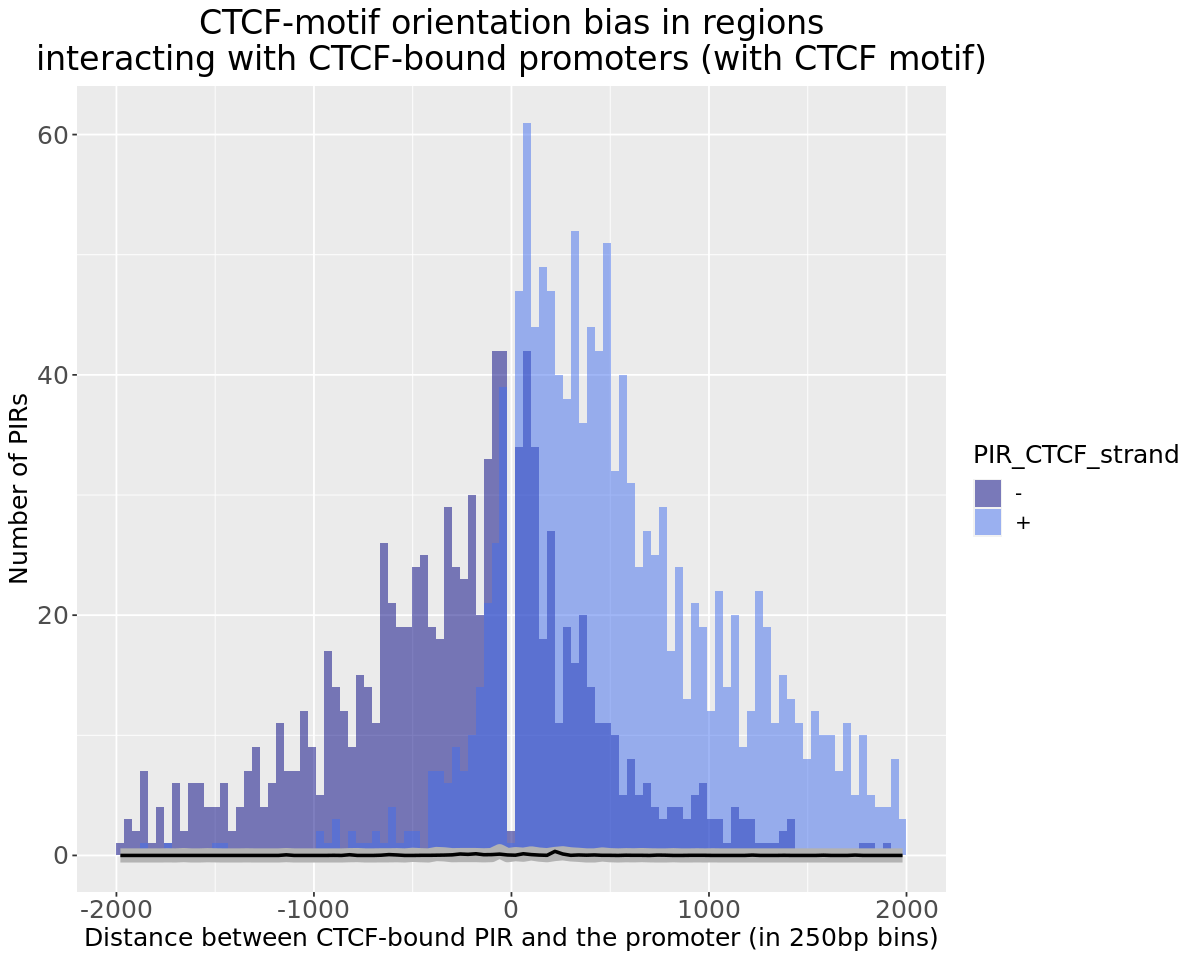

In [191]:
data_h <- filter(loops_PIR_and_bait_motifs_flipped, PIR_CTCF_strand_flipped %in% c("-","+"))
options(repr.plot.width=10, repr.plot.height=8)
ggplot() + geom_histogram(data=data_h, aes(data_h$V7,fill=PIR_CTCF_strand_flipped),alpha=0.5, bins = 100, position="identity") + 
scale_fill_manual(values=c("navyblue","royalblue2"))+ labs(fill="PIR_CTCF_strand")+
xlim(-2000,2000)+ geom_line(aes(stat_m$coord, stat_m$sum), color="grey70", size=4) + geom_line(aes(stat_p$coord, stat_p$sum), size=1)+
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=15),
     plot.title=element_text(size=20, hjust=0.5)) + labs(y="Number of PIRs",x="Distance between CTCF-bound PIR and the promoter (in 250bp bins)")+
ggtitle("CTCF-motif orientation bias in regions\ninteracting with CTCF-bound promoters (with CTCF motif)")
ggsave("Figures/Fig.S4/S4a_CTCF_motif_orientation_bias_CTCF_bound_promoters_with_motifs.pdf",device="pdf",width=10, height=8)

# Analysis of factor enrichment in PIRs

In [203]:
# do clean up in tmp directory and in the environment
rm(list=ls())
# loading peak positions for 271 ChIP-seq experiments in K562 cells (TFs and some epigenomic marks)
read_bed <- function(x){
  bed <- read.csv(paste0(folder,x[1,2]), header = F, sep = "\t")
  if("V8" %in% colnames(bed)){
  if(sum(bed$V8) < 0) {bed <- filter(bed, V7>25)} else {bed <- filter(bed, V8>20)}}
  return(bed)  
}
folder <- "Auxiliary_data/peaks/"
list <- read.csv("Auxiliary_data/list_of_files.txt", header = F, sep = "\t")[,1:2]
colnames(list) <- c("target","bed")
list <- split(list, list$target)
beds <- lapply(list, read_bed)

In [204]:
# calculating number of PIRs overlapping peaks
loops <-read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
loops$V7 <- 0
loops$V7[loops$V2>loops$V5] <- -((loops$V2[loops$V2>loops$V5]-loops$V6[loops$V2>loops$V5])/250+1)
loops$V7[loops$V2<loops$V5] <- (loops$V5[loops$V2<loops$V5]-loops$V3[loops$V2<loops$V5])/250+1
mask <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/H3K4me3.mask.bed", header = F, sep = "\t")[,c(1:3)]
loops_OE_ranges <- GRanges(seqnames = loops$V4, ranges=IRanges(start=loops$V5, end=loops$V6))
mask_ranges <- GRanges(seqnames = mask$V1, ranges=IRanges(start=mask$V2-250, end=mask$V3+250))
PIRs <- unique(loops[-(as.data.frame(findOverlaps(loops_OE_ranges,mask_ranges))[,1]),c(4:6)])
write.table(PIRs, file="tmp/PIRs.bed", col.names = F, row.names = F, sep = "\t", quote = F)
PIR_ranges <- GRanges(seqnames = PIRs$V4, ranges=IRanges(start=PIRs$V5, end=PIRs$V6))
peak_ranges <- lapply(beds, function(bed){GRanges(seqnames = bed$V1, ranges=IRanges(start=bed$V2, end=bed$V3))})
number_of_overlaps <- sapply(peak_ranges, function(range){length(unique(as.data.frame(findOverlaps(PIR_ranges, range))[,1]))})

In [205]:
# sampling random PIR-like regions 100 times and calculating number of expected (by chance) overlaps with peaks
set.seed(42)
randomized_numbers <- c()
for (i in seq(100)){
  randomized_OE <- loops[,1:6]
  randomized_OE$V7 <- sample(loops$V7)
  randomized_pos <- filter(randomized_OE, V7 > 0)
  randomized_neg <- filter(randomized_OE, V7 < 0)
  randomized_pos$V6 <- randomized_pos$V3 + randomized_pos$V7 * 250
  randomized_pos$V5 <- randomized_pos$V6 - 250
  randomized_neg$V5 <- randomized_neg$V2 + randomized_neg$V7 *250
  randomized_neg$V6 <- randomized_neg$V5 + 250
  PIRs_randomized <- unique(bind_rows(randomized_pos, randomized_neg)[,c(4:6)])
  PIR_randomized_ranges <- GRanges(seqnames = PIRs_randomized$V4, ranges=IRanges(start=PIRs_randomized$V5, end=PIRs_randomized$V6))
  PIRs_randomized <- sample_n(PIRs_randomized[-unique(as.data.frame(findOverlaps(PIR_randomized_ranges,mask_ranges))[,1]),], nrow(PIRs))
  PIR_randomized_ranges <- GRanges(seqnames = PIRs_randomized$V4, ranges=IRanges(start=PIRs_randomized$V5, end=PIRs_randomized$V6))
  randomized_number_of_overlaps <- sapply(peak_ranges,function(range){length(unique(as.data.frame(findOverlaps(PIR_randomized_ranges, range))[,1]))})
  randomized_numbers <- bind_rows(randomized_numbers, randomized_number_of_overlaps)}

In [206]:
# looking for motif enrichment in PIRs with homer
system("findMotifsGenome.pl tmp/PIRs.bed hg19 tmp/homer_output/ -nomotif -p 16")
motif_enrichment <- read.csv("tmp/homer_output/knownResults.txt", header = T, sep = "\t")
mot <- system("conda info | grep 'active env location' | cut -d ':' -f 2", intern=T)
mot <- substr(mot, 2, nchar(mot))
mot <- paste0(mot,"/share/homer/motifs/table.txt")
motifs <- read.csv(mot, header = T, sep = "\t")
motifs["Symbol"][motifs["Factor.Name"]=="Gata1"] <- "GATA1"
motif_enrichment <- left_join(motif_enrichment,motifs[c("Name","Symbol")], by=c("Motif.Name"="Name"))

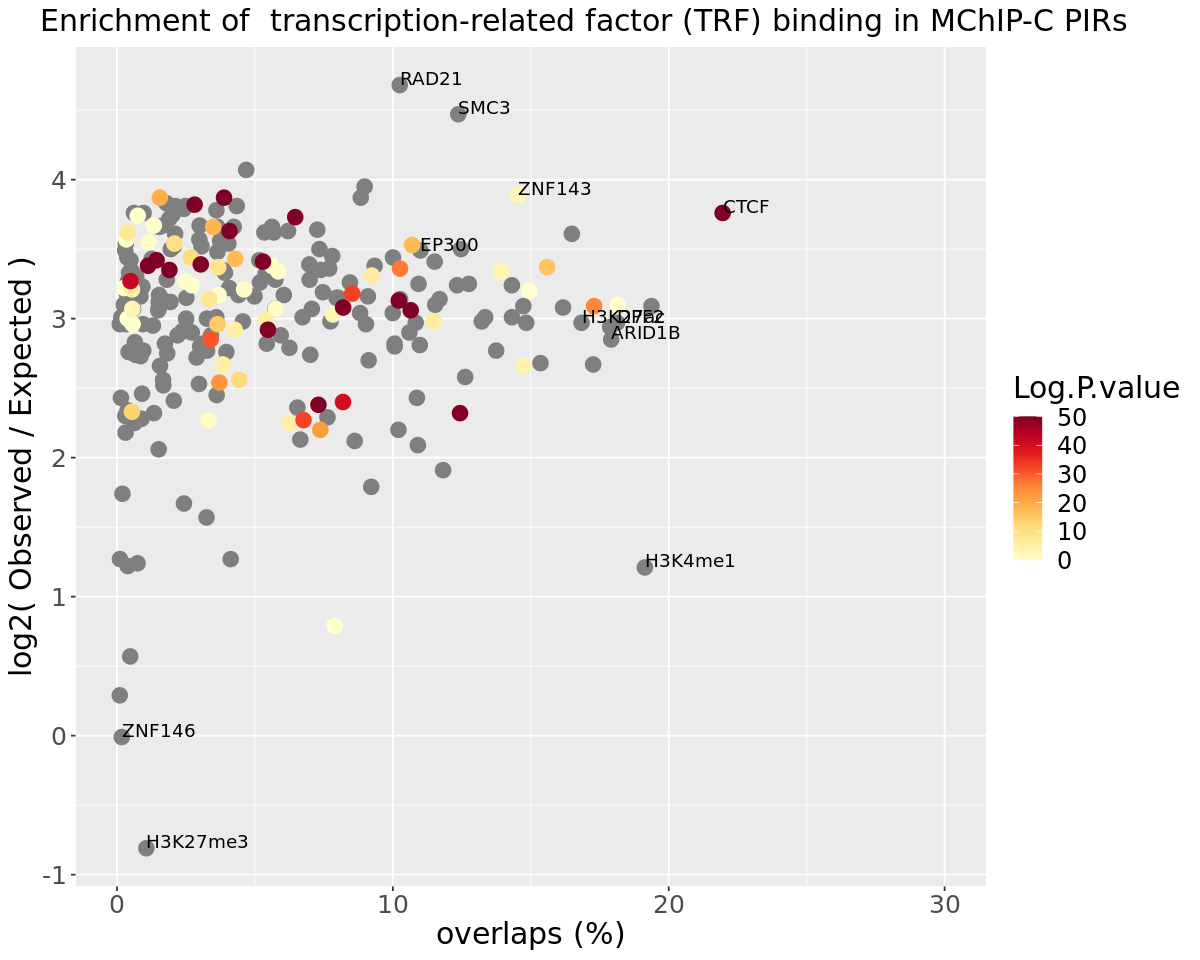

In [207]:
# summarizing and plotting the data
summary <- data_frame(ChIP=colnames(randomized_numbers), overlaps = number_of_overlaps, 
                      randomized_mean = colMeans(randomized_numbers), 
                      sd = as.numeric(summarise_if(randomized_numbers,is.numeric, sd)))
summary$enrichment <- summary$overlaps / summary$randomized_mean
melted <- melt(summary[,1:4], c("ChIP","sd"))
for (i in seq(nrow(melted))){
  if (melted[i,3]=="overlaps"){melted[i,2] <- 0}}
summary <- left_join(summary, motif_enrichment[c("Symbol","Log.P.value")], by=c("ChIP"="Symbol"))
summary["Log.P.value"] <- -(summary["Log.P.value"])
summary$sd <- round(summary$sd,2)
summary$enrichment <- round(log2(summary$enrichment),2)
write.table(summary, file="Summary_output_datasets/TF_enrichment_in_PIRs.txt", col.names = T, row.names = F, sep = "\t", quote = F)
summary$Log.P.value[summary$Log.P.value > 50] <- 50
summary <- summary %>% arrange(!is.na(Log.P.value), Log.P.value)
summary <- filter(summary, overlaps >100)
mycolors <- colorRampPalette(brewer.pal(9, "YlOrRd"))(50)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(summary, aes(overlaps*100/nrow(PIRs),enrichment)) + geom_point(aes(colour=Log.P.value), size=4) +  
   geom_text(aes(label=ifelse(ChIP %in% c("H3K4me1", "H3K27ac", "CTCF","SMC3", "RAD21", "ARID1B","H3K27me3",
                             "EP300", "DPF2","ZNF143", "ZNF146", "BRD4"),as.character(ChIP),'')),hjust=0,vjust=0) +
   scale_colour_gradientn(colours=mycolors, limits=c(0, 50))+
   xlab("overlaps (%)") + ylab("log2( Observed / Expected )")+xlim(0,30)+theme_classic()
   theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),
   text=element_text(size=18), plot.title=element_text(size=18, hjust=0.2))+
   ggtitle("Enrichment of  transcription-related factor (TRF) binding in MChIP-C PIRs")

# Hierarchical clustering of DHSs overlapping PIRs

In [208]:
# loading DNase peaks and selecting DNase peaks overlapping PIRs:
rm(list=ls()[!((ls()%in%c("PIR_ranges","peak_ranges")))])
DNase <- read.csv("Auxiliary_data/peaks/ENCFF621ZJY.bed.gz", header = F, sep = "\t")
DNase <-filter(DNase, V7>200)
DNase_ranges <- GRanges(seqnames = DNase$V1, ranges=IRanges(start=DNase$V2, end=DNase$V3))
DNase <- DNase[unique(as.data.frame(findOverlaps(DNase_ranges,PIR_ranges))[,1]), 1:3]
write.table(DNase, "tmp/DNase.bed", quote=F, sep = "\t", col.names = F, row.names = F)

In [209]:
DNase <- read.csv("tmp/DNase.bed", header = F, sep = "\t")
DNase_in_PIRs_ranges <- GRanges(seqnames = DNase$V1,ranges=IRanges(start=DNase$V2, end=DNase$V3))
# finding overlaps with peaks:
overlaps <- sapply(peak_ranges, function(range){
    unique(as.data.frame(findOverlaps(DNase_in_PIRs_ranges, range))[,1])})
for (i in seq(length(overlaps))){
  DNase[names(overlaps)[i]] <- 0
  DNase[names(overlaps)[i]][unlist(overlaps[i]),] <- 1}
colnames(DNase)[1:3] <- c("DNase_chr","DNase_start","DNase_end")

In [210]:
enrichment <- read.csv("Summary_output_datasets/TF_enrichment_in_PIRs.txt", header = T, sep = "\t")
enrichment <- filter(enrichment, enrichment > 2)
for (i in seq(ncol(DNase),4)){
  if (sum(DNase[,i]) < 1500) {DNase[,i] <- NULL}
  if (!(colnames(DNase)[i] %in% enrichment$ChIP)) {DNase[,i] <- NULL}}

In [211]:
distance <- dist(DNase[,4:ncol(DNase)], method="binary")
cl <- hclust(distance, method="ward.D")
cl$height <- round(cl$height, 6)
dend1 <- as.dendrogram(cl)
DNase$cluster <- dendroextras::slice(dend1, k=5)[as.character(1:nrow(DNase))]
DNase <- DNase[labels(dend1),]

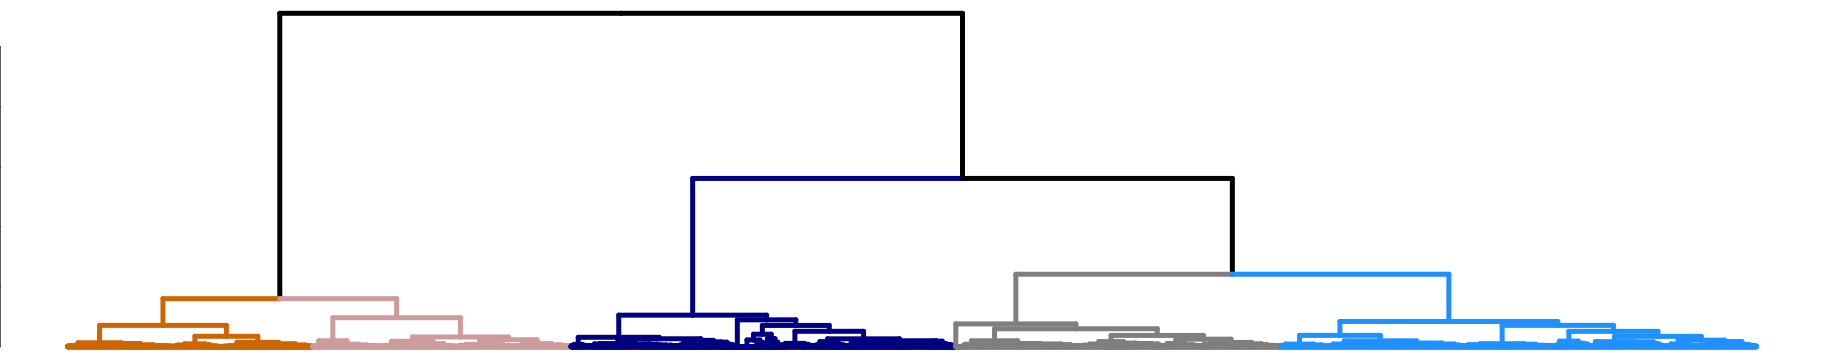

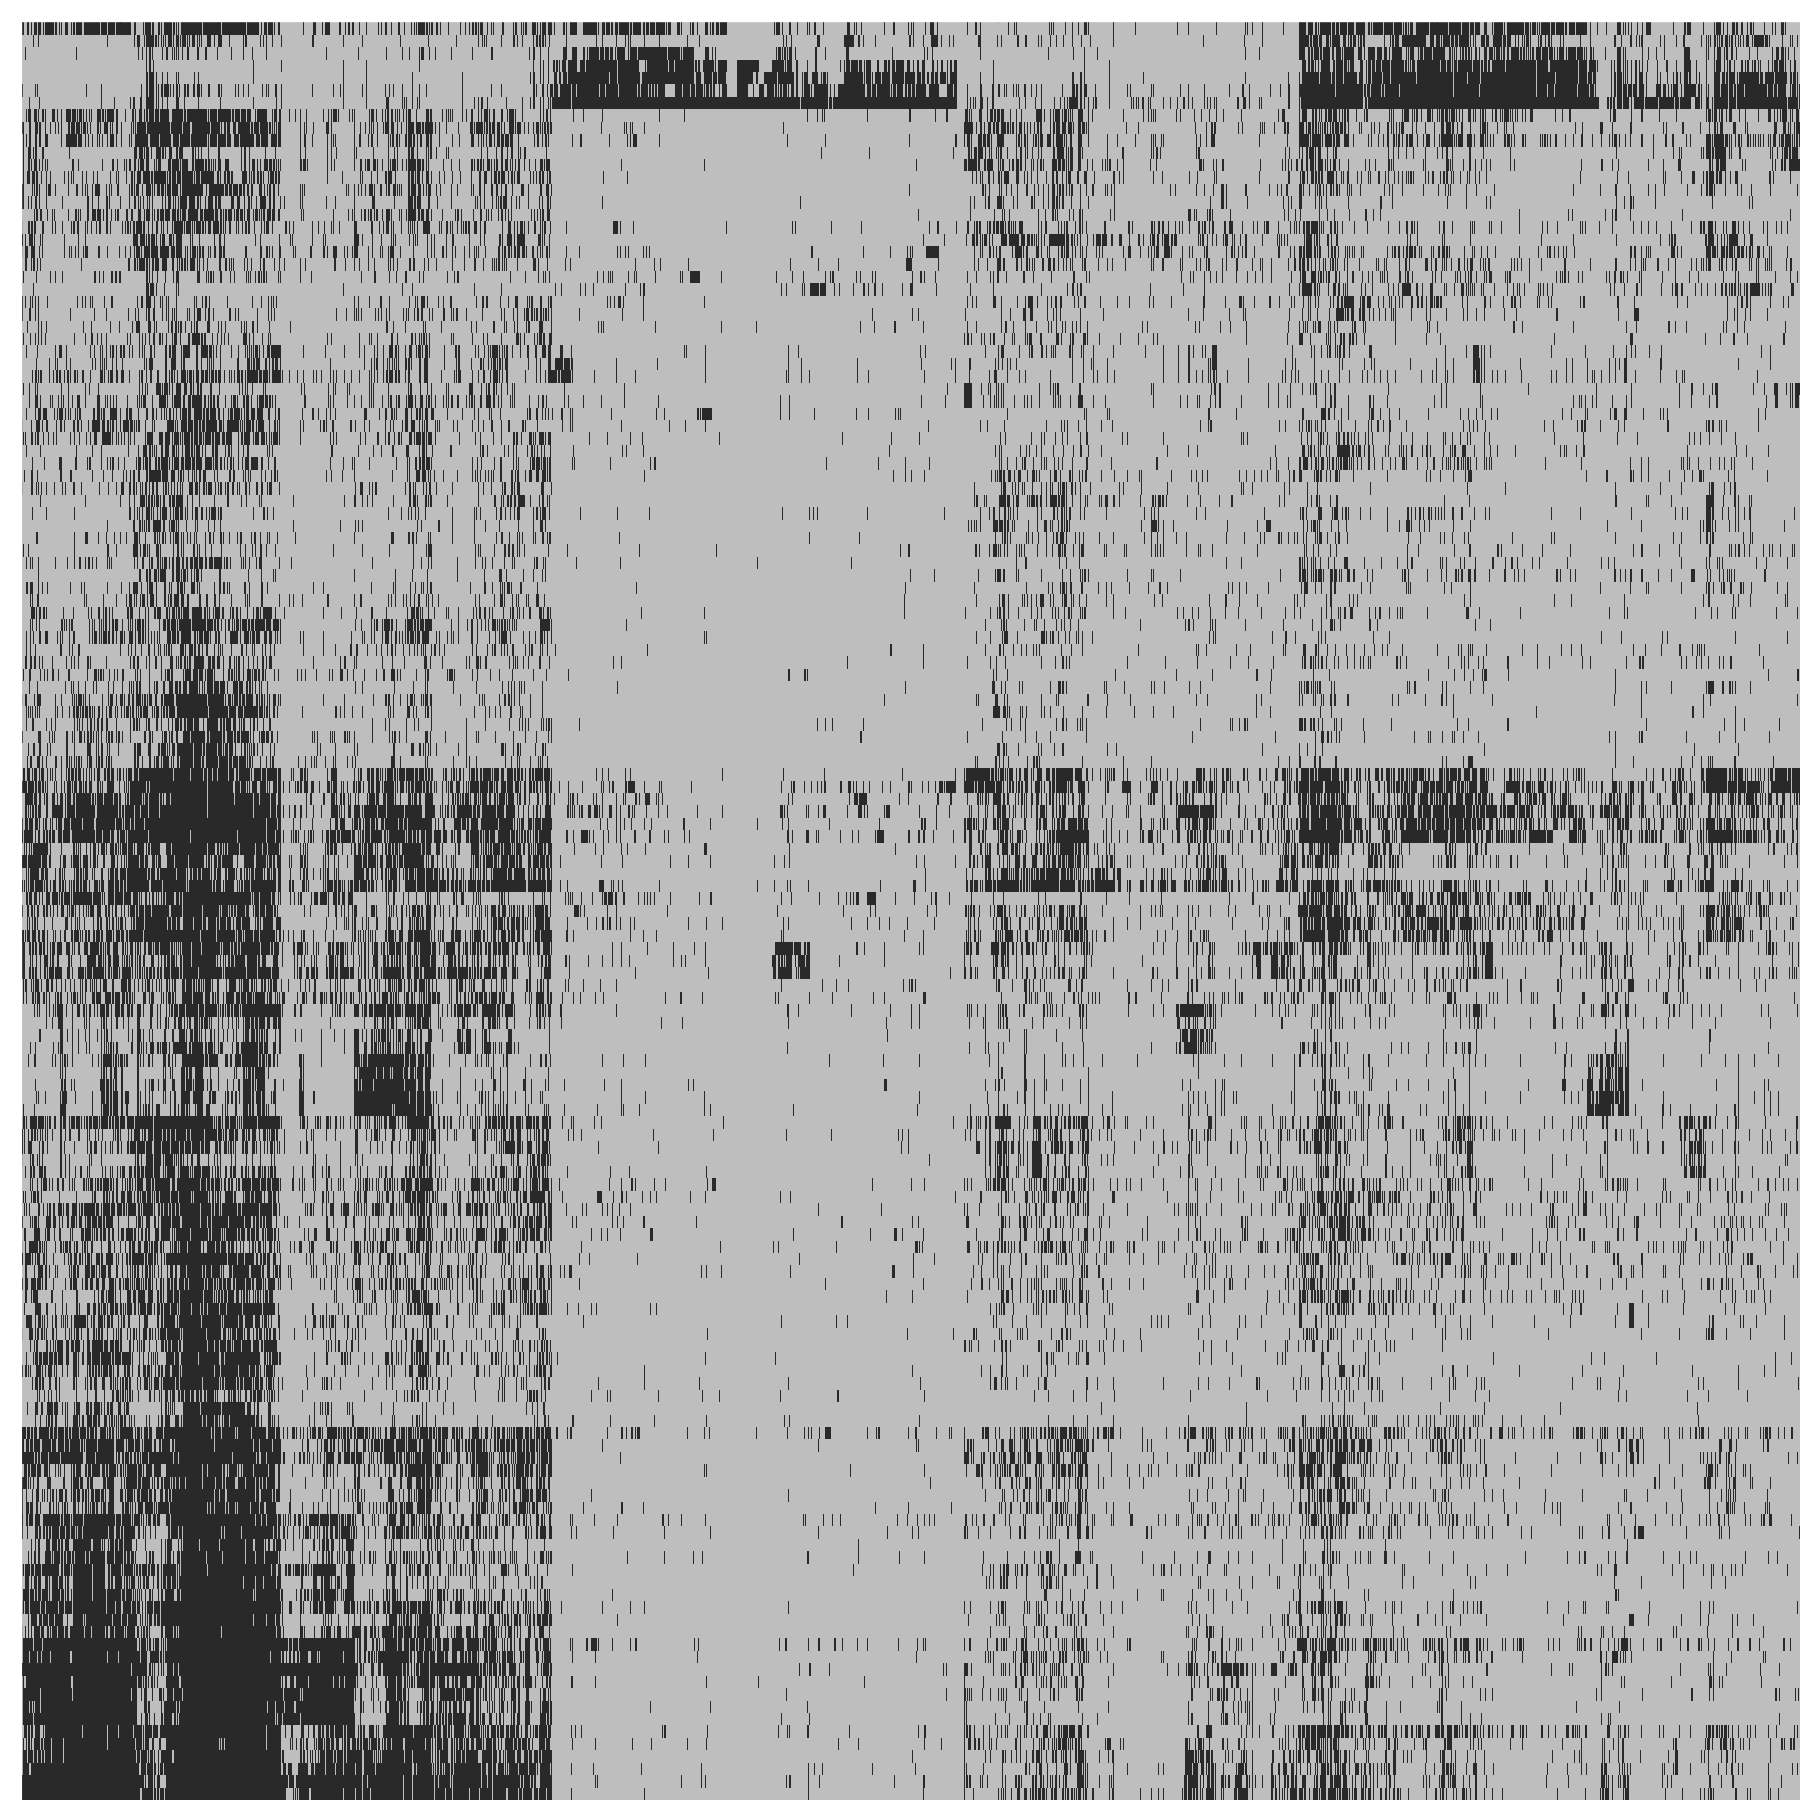

In [216]:
dend2<-color_branches(dend1,groupLabels=F,k=5,col=c("darkorange3","rosybrown3","navyblue","grey50","dodgerblue"))
labels(dend2) <- NULL
options(repr.plot.width=15.2, repr.plot.height=3)
par(mar=c(0,0,0,0))
dend2 %>% set("branches_lwd",4) %>% plot()
dd <- as.dendrogram(hclust(dist(t(as.matrix(DNase[,4:(ncol(DNase)-1)])))))
RM <- rowMeans(t(as.matrix(DNase[,4:(ncol(DNase)-1)])))
dd <- reorder(dd, RM)
options(repr.plot.width=15, repr.plot.height=15)
heatmap(t(as.matrix(DNase[labels(dd)])), Colv = NA, Rowv=NA, margins=c(0,0),
                        scale="none",labRow = FALSE, labCol = FALSE, revC=T, col=c("grey","grey16"))

In [377]:
N_DNase <- nrow(DNase)
N_cluster_1 <- sum(DNase$cluster==1)
N_cluster_2 <- sum(DNase$cluster==2)
N_cluster_3 <- sum(DNase$cluster==3)
N_cluster_4 <- sum(DNase$cluster==4)
N_cluster_5 <- sum(DNase$cluster==5)
cat(paste0("As a result of hierarchical clustering we called 5 clusters of DHSs according to TRF binding.\n",
           N_cluster_1, " of ",N_DNase, " DHSs overlapping MChIP-C PIRs belong to cluster 1.\n",
           N_cluster_2, " - to cluster 2, ", N_cluster_3, " - to cluster 3, ", N_cluster_4, " - to cluster_4, ",
           "and ", N_cluster_5, " - to cluster 5."))

As a result of hierarchical clustering we called 5 clusters of DHSs according to TRF binding.
2776 of 19102 DHSs overlapping MChIP-C PIRs belong to cluster 1.
2919 - to cluster 2, 4350 - to cluster 3, 3678 - to cluster_4, and 5379 - to cluster 5.

In [224]:
match(c("RAD21","SMC3","ZNF143","CTCF","BRD4","H3K27ac","SMARCE1",
        "ARID1B","DPF2","TEAD4","EP300","YY1","MED1","CDK8",'POLR2AphosphoS5'),labels(dd))

[1]   4   5   6   7  70  69 140 142 143 131 132  20  59  53 125

In [384]:
feature_sum <- DNase[,4:ncol(DNase)] %>% group_by(cluster) %>% summarise_each(mean)
feature_sum <- as.data.frame(t(feature_sum[,2:ncol(feature_sum)]))
colnames(feature_sum) <- c("cluster_1","cluster_2","cluster_3","cluster_4","cluster_5")
filter(feature_sum, rownames(feature_sum)%in%c("CTCF","SMC3","RAD21","ZNF143","DPF2","ARID1B","SMARCE1","EP300"))

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARID1B,0.95497118,0.91675231,0.012873563,0.28711256,0.1777282
CTCF,0.12175793,0.10208976,0.988505747,0.18868951,0.9167131
DPF2,0.97514409,0.88317917,0.010344828,0.33768352,0.1987358
EP300,0.95317003,0.68311065,0.009655172,0.13648722,0.1451943
RAD21,0.03134006,0.01541624,0.629885057,0.01658510,0.6146124
SMARCE1,0.93479827,0.73347037,0.003218391,0.23599782,0.1228853
SMC3,0.05763689,0.02432340,0.770574713,0.03289831,0.7607362
ZNF143,0.18876081,0.09249743,0.734942529,0.10522023,0.8100019


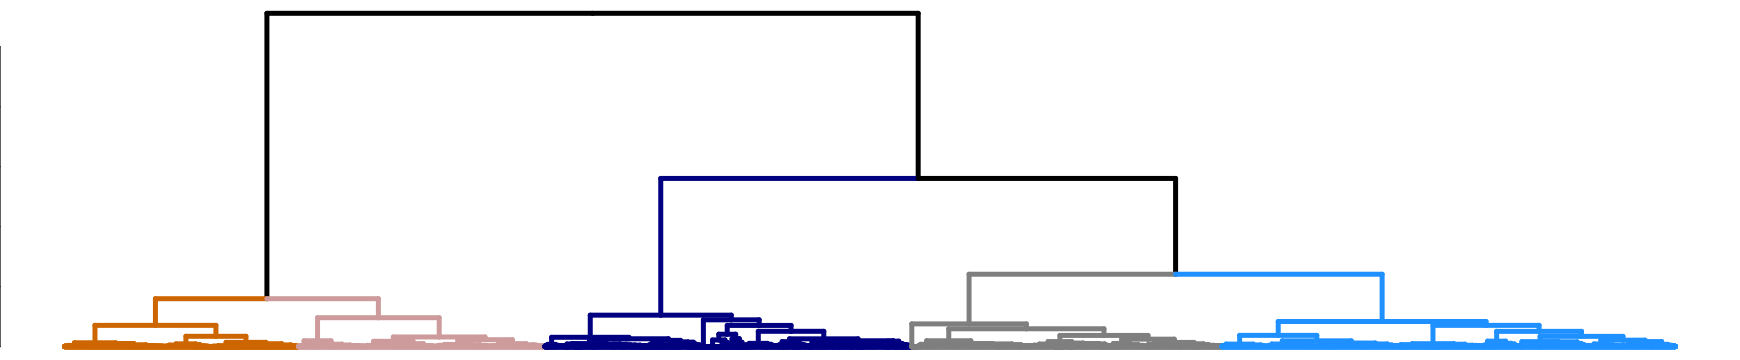

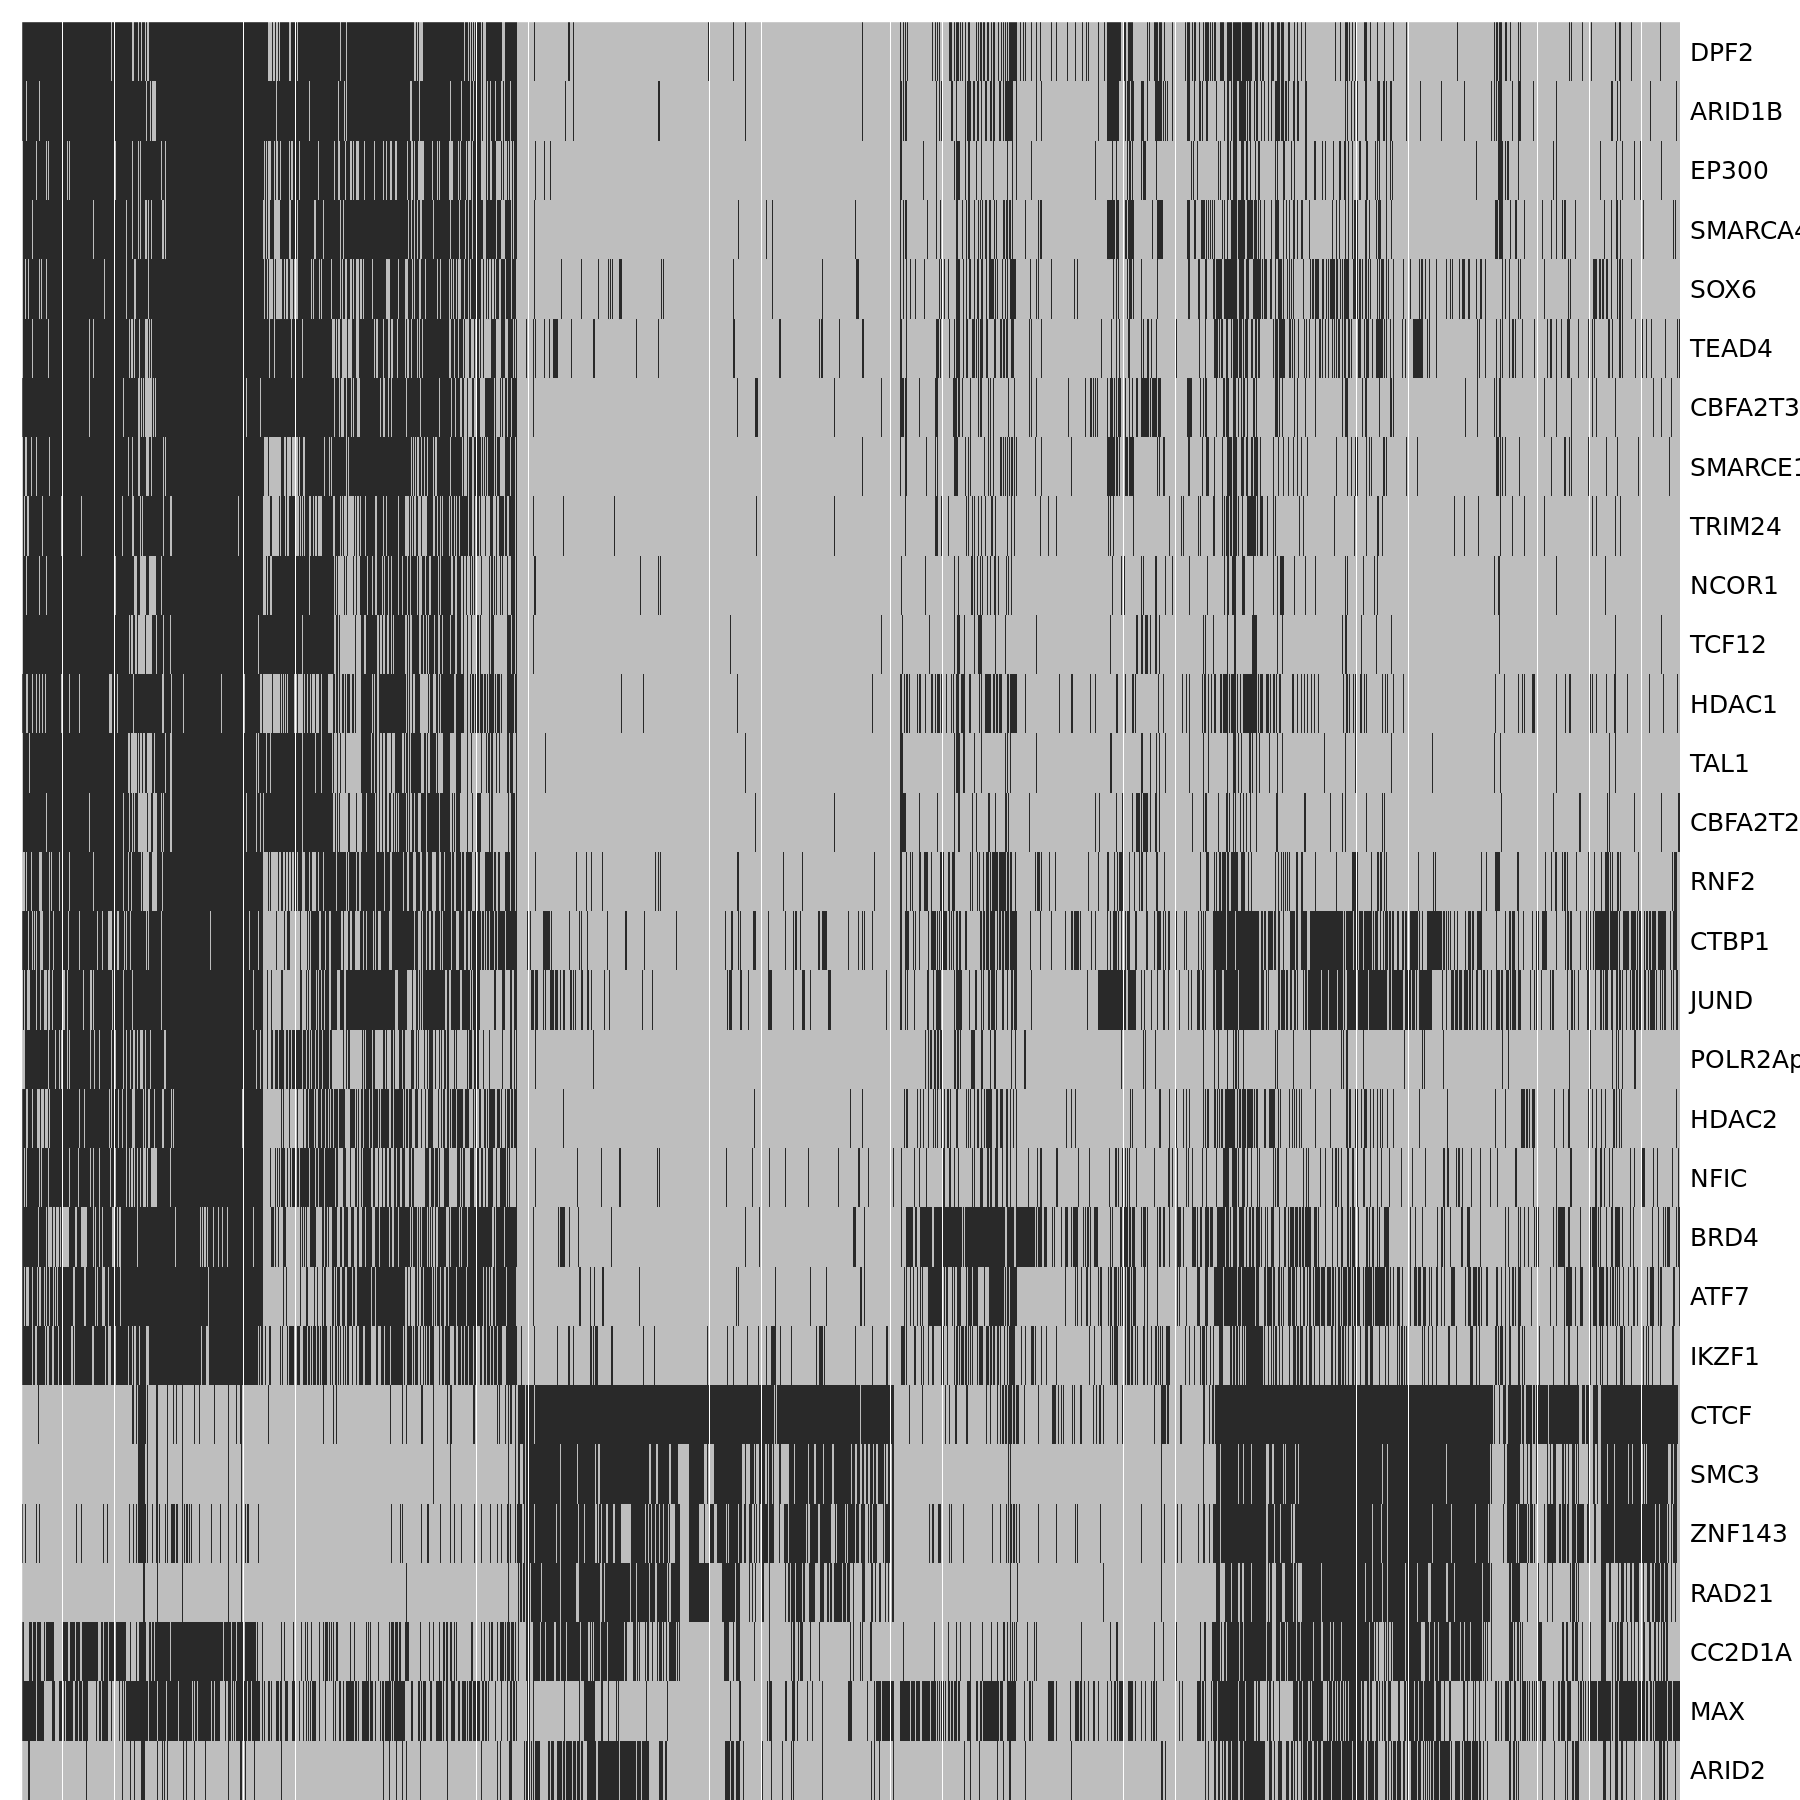

In [223]:
features <- c()
features <- append(features, rownames(arrange(feature_sum, desc(V1)) %>% filter(V1>0.5))[1:20])
features <- append(features, rownames(arrange(feature_sum, desc(V2)) %>% filter(V2>0.5))[1:20])
features <- append(features, rownames(arrange(feature_sum, desc(V3))  %>% filter(V3>0.5))[1:20])
features <- append(features, rownames(arrange(feature_sum, desc(V4))  %>% filter(V4>0.5))[1:20])
features <- append(features, rownames(arrange(feature_sum, desc(V5))  %>% filter(V5>0.5))[1:20])
features <- unique(features)
features <- features[!(is.na(features))]
options(repr.plot.width=14.5, repr.plot.height=3)
par(mar=c(0,0,0,0))
dend2 %>% set("branches_lwd",4) %>% plot()
options(repr.plot.width=15, repr.plot.height=15)
heatmap(t(as.matrix(DNase[features])), Colv = NA, Rowv = NA, scale = "none",margins = c(0,6),labCol=NA,
        labRow = colnames(DNase[features]),revC=T, col=c("grey","grey16"), cexRow = 1.5)

In [291]:
# counting overlaps with CRISPRi-verified enhancers
gasperini_neg <- read.csv("Auxiliary_data/CRISPRi_data/GSE120861_all_deg_results.at_scale.txt.gz", 
                          header = T, sep = "\t")
genes <- unique(gasperini_neg[,c(9,16)])
genes <- filter(genes, !(duplicated(genes$gene_short_name)))
gasperini_neg <- filter(gasperini_neg, quality_rank_grna=="top_two" & !(outlier_gene) &
                        fold_change.transcript_remaining<1.1 &
                        (pvalue.empirical.adjusted > 0.1|pvalue.empirical.adjusted=="not_applicable"))
gasperini_neg <- gasperini_neg[,c(12:14,9,16)]
gasperini_neg$Significant <- FALSE
gasperini_neg[,2] <- as.integer(gasperini_neg[,2])
gasperini_neg[,3] <- as.integer(gasperini_neg[,3])
gasperini_pos <- read_excel("Auxiliary_data/CRISPRi_data/Gasperini2019_TableS2.xlsx", sheet = 3)
gasperini_pos <- filter(gasperini_pos, high_confidence_subset)
gasperini_pos <- gasperini_pos[,c(9:11,3)]
colnames(gasperini_pos) <- colnames(gasperini_neg)[1:4]
gasperini_pos <- left_join(gasperini_pos,genes)
gasperini_pos$Significant <- TRUE
fulco <- read_excel("Auxiliary_data/CRISPRi_data/Fulco2019_SupTables.xlsx", sheet = 16, skip = 1)
fulco <- filter(fulco, class != "promoter" & 
                ((`Fraction change in gene expr`< 0 & Significant == T)| (Significant == F)))
fulco <- fulco[,c(1,2,3,5,18,10)]
colnames(fulco) <- colnames(gasperini_neg)
enhancers <- bind_rows(gasperini_pos, gasperini_neg,fulco) %>% filter(Significant)

Joining, by = "gene_short_name"


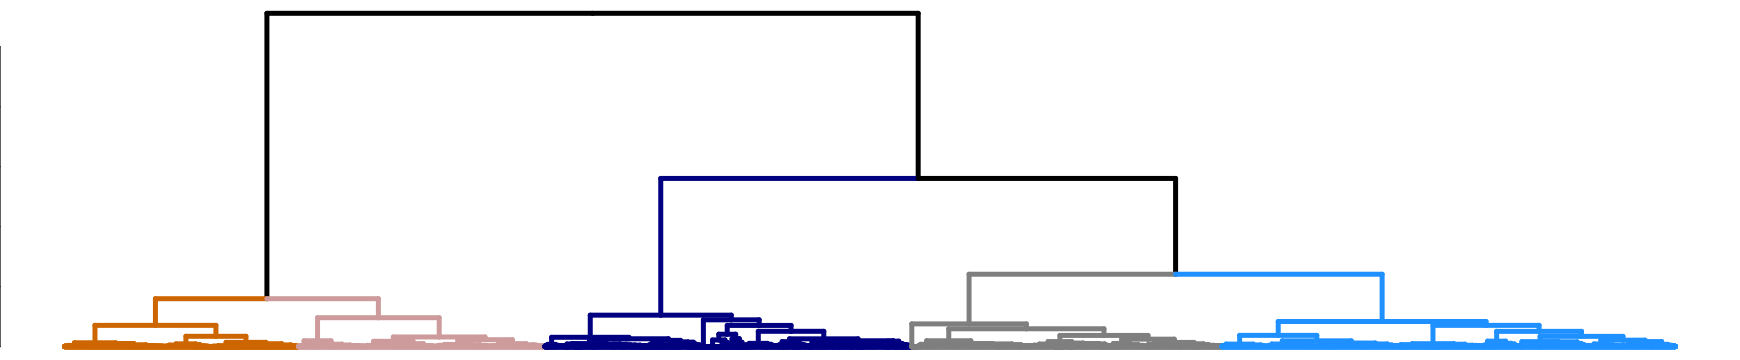

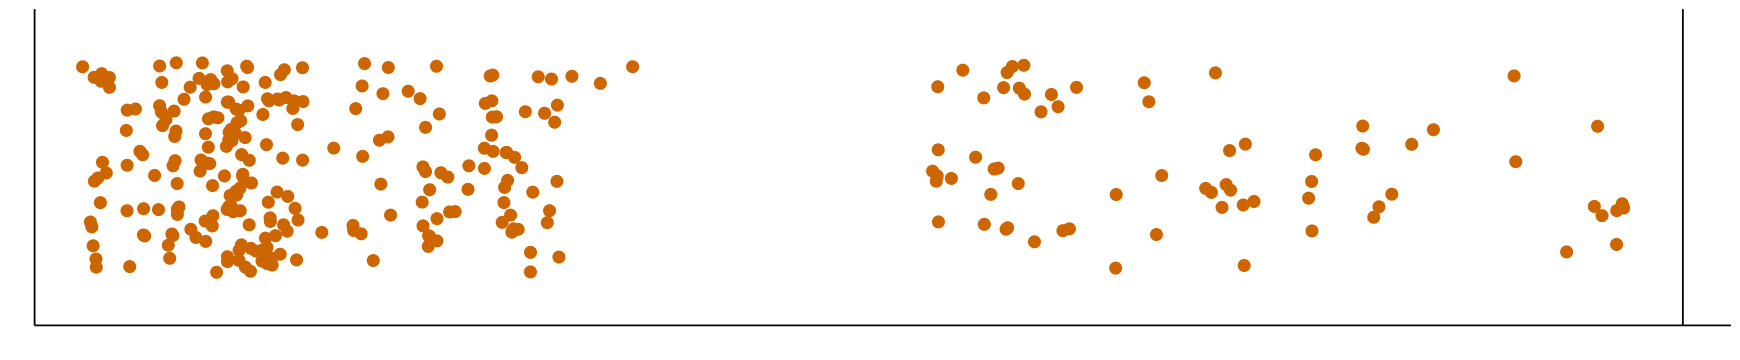

In [329]:
enhancer_ranges <- GRanges(seqnames = enhancers$target_site.chr, 
                           ranges=IRanges(start=enhancers$target_site.start, end=enhancers$target_site.stop))
DNase_ranges <- GRanges(seqnames = DNase$DNase_chr, ranges=IRanges(start=DNase$DNase_start, end=DNase$DNase_end))
DNase$number <- 1:nrow(DNase)
DNase$enhancer_overlap <- DNase$number %in% unique(as.data.frame(findOverlaps(DNase_ranges,enhancer_ranges))[,1])
options(repr.plot.width=14.5, repr.plot.height=3)
par(mar=c(0,0,0,0))
dend2 %>% set("branches_lwd",4) %>% plot()
options(repr.plot.width=14.5, repr.plot.height=3)
ggplot(filter(DNase, enhancer_overlap)) + 
           geom_jitter(aes(number, enhancer_overlap),color="darkorange3", size=3, height = 0.4)+theme_classic()+
           theme(axis.text=element_blank(), axis.ticks=element_blank())+
           geom_vline(xintercept=nrow(DNase))+xlab("")+ylab("")+scale_x_continuous(expand=c(0.03,0))

In [354]:
sum_1<-binom.test(sum(filter(DNase, cluster==1)$enhancer_overlap), 
                  sum(DNase$enhancer_overlap), nrow(filter(DNase, cluster==1))/nrow(DNase), alternative = "g")
sum_2<-binom.test(sum(filter(DNase, cluster==2)$enhancer_overlap), 
                  sum(DNase$enhancer_overlap), nrow(filter(DNase, cluster==2))/nrow(DNase), alternative = "g")
sum_3<-binom.test(sum(filter(DNase, cluster==3)$enhancer_overlap), 
                  sum(DNase$enhancer_overlap), nrow(filter(DNase, cluster==3))/nrow(DNase), alternative = "g")
sum_4<-binom.test(sum(filter(DNase, cluster==4)$enhancer_overlap), 
                  sum(DNase$enhancer_overlap), nrow(filter(DNase, cluster==4))/nrow(DNase), alternative = "g")
sum_5<-binom.test(sum(filter(DNase, cluster==5)$enhancer_overlap), 
                  sum(DNase$enhancer_overlap), nrow(filter(DNase, cluster==5))/nrow(DNase), alternative = "g")
cat(paste0("P-values for overrepresentation (binomial test) of CRISPRi-verified enhancers in clustres are:\n",
          signif(sum_1$p.value, digits=3), " (number of trials: ", sum_1$parameter, ", number of successes: ",sum_1$statistic , ") - for cluster 1;\n",
          signif(sum_2$p.value, digits=3), " (number of successes: ", sum_2$statistic, ") - for cluster 2;\n",
          signif(sum_3$p.value, digits=3), " (number of successes: ", sum_3$statistic, ") - for cluster 3;\n",
          signif(sum_4$p.value, digits=3), " (number of successes: ", sum_4$statistic, ") - for cluster 4;\n",
          signif(sum_5$p.value, digits=3), " (number of successes: ", sum_5$statistic, ") - for cluster 5."))

P-values for overrepresentation (binomial test) of CRISPRi-verified enhancers in clustres are:
7.77e-53 (number of trials: 301, number of successes: 157) - for cluster 1;
0.000104 (number of successes: 71) - for cluster 2;
1 (number of successes: 4) - for cluster 3;
0.99 (number of successes: 43) - for cluster 4;
1 (number of successes: 26) - for cluster 5.

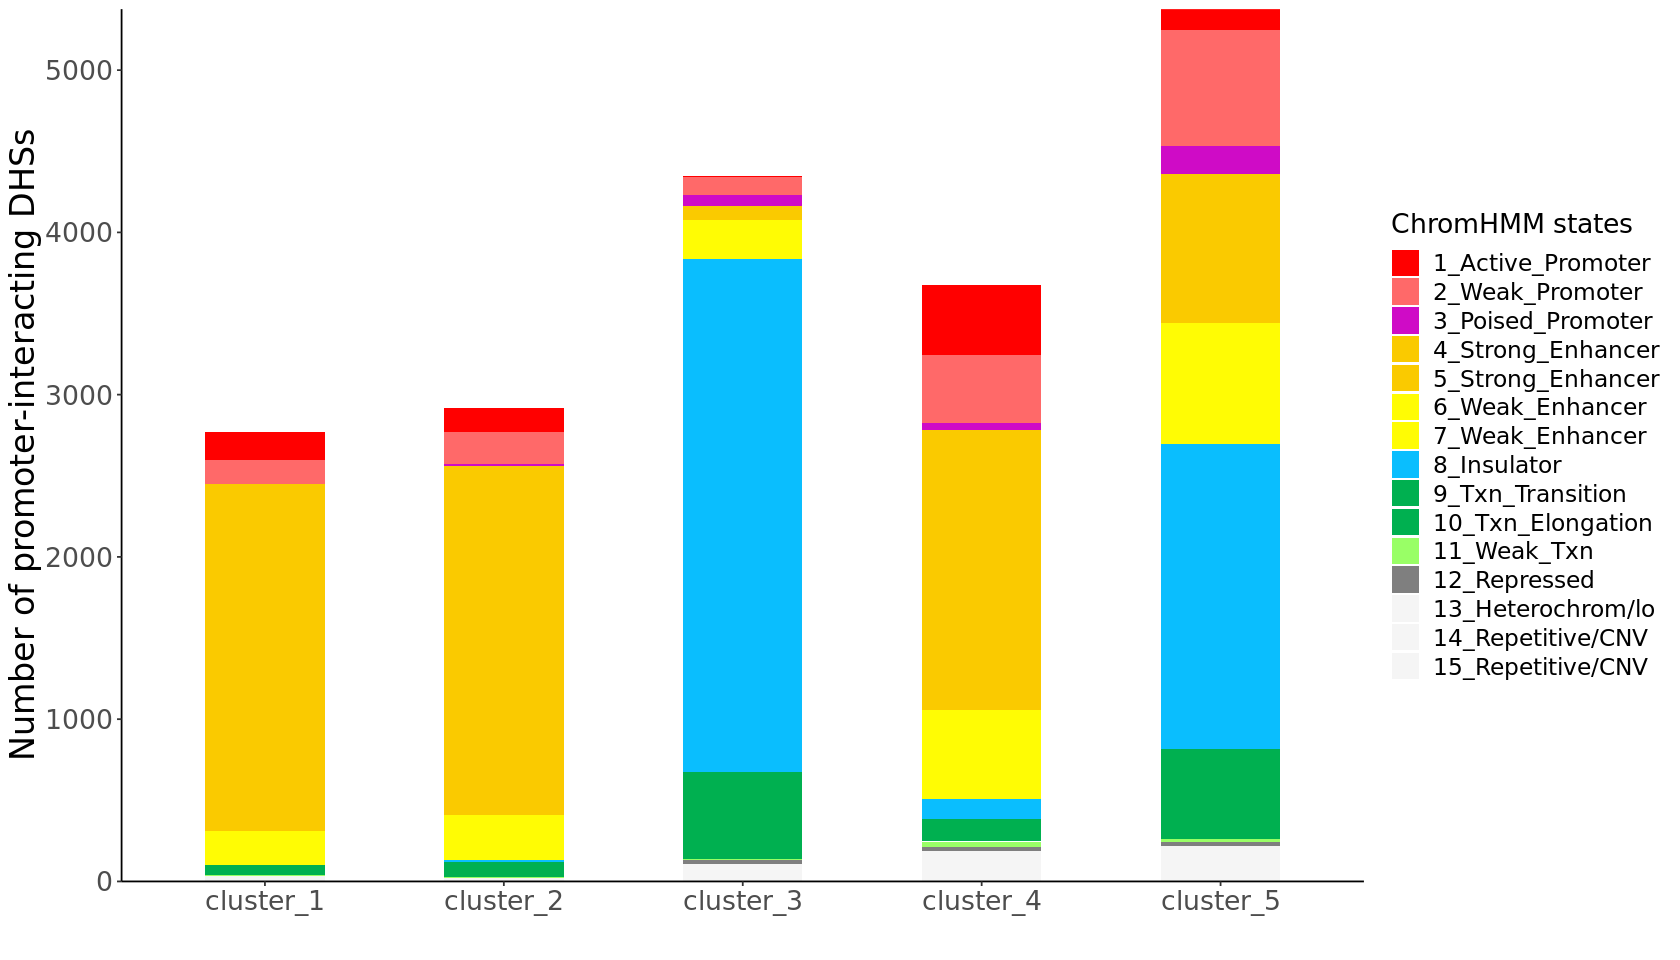

In [278]:
HMM <- read.csv("Auxiliary_data/wgEncodeBroadHmmK562HMM.bed.gz", header = F, sep = "\t")
HMM$subjectHits <- seq(1, nrow(HMM))
for (i in 1:nrow(HMM)){
  HMM$V9[i] <- rgb(as.numeric(strsplit(HMM$V9[i], split=",")[[1]])[1], as.numeric(strsplit(HMM$V9[i], split=",")[[1]])[2], as.numeric(strsplit(HMM$V9[i], split=",")[[1]])[3], maxColorValue = 255)}
HMM_ranges <- GRanges(seqnames = HMM$V1, ranges=IRanges(start=HMM$V2, end=HMM$V3, enh_id = seq(1,nrow(HMM))))

summary <- data.frame()
add_to_summary<- function(x){
  cluster <- filter(DNase, cluster==x)[,1:3]
  cluster$queryHits <- seq(1,nrow(cluster))
  cluster_ranges<-GRanges(seqnames=cluster$DNase_chr,
                          ranges=IRanges(start=cluster$DNase_start,end=cluster$DNase_end)) 
  suppressMessages({cluster<-left_join(cluster,as.data.frame(findOverlaps(cluster_ranges,HMM_ranges,
    minoverlap = 76))[!(duplicated(as.data.frame(findOverlaps(cluster_ranges, HMM_ranges, minoverlap = 76))[,1])),])})
  suppressMessages({cluster <- left_join(cluster, HMM[,c(4,9,10)])})
  cluster <- cluster[!(is.na(cluster$V9)),]
  summary <- cluster %>% group_by(V4) %>% summarise(N=length(V4), color=unique(V9), cluster=paste0("cluster_",x))
  return(summary)}
for (i in seq(1:5)){
  summary <- rbind(summary, add_to_summary(i))}
summary$V5 <- as.numeric(unlist(lapply(strsplit(summary$V4, split="_"), `[[`, 1)))
summary <- arrange(summary, V5)
options(repr.plot.width=14, repr.plot.height=8)
ggplot(summary) + geom_col(aes(x=cluster, y=N, fill=factor(V4, levels=unique(V4))), width=0.5) + 
                   ylab("Number of promoter-interacting DHSs")+xlab("")+theme_classic()+labs(fill="ChromHMM states")+
                   theme(axis.text=element_text(size=16),axis.title=element_text(size=20), 
                         legend.title=element_text(size=16), legend.text=element_text(size=14))+
                   scale_fill_manual(values=summary$color[!duplicated(summary$V4)])+
                   scale_y_continuous(expand=c(0,0))

Median span of structural loops anchored on DHSs from clusters 3 and 5 is 89 kb,
whereas median span of regulatory loops anchored on DHSs from cluster 1 is 48 kb.

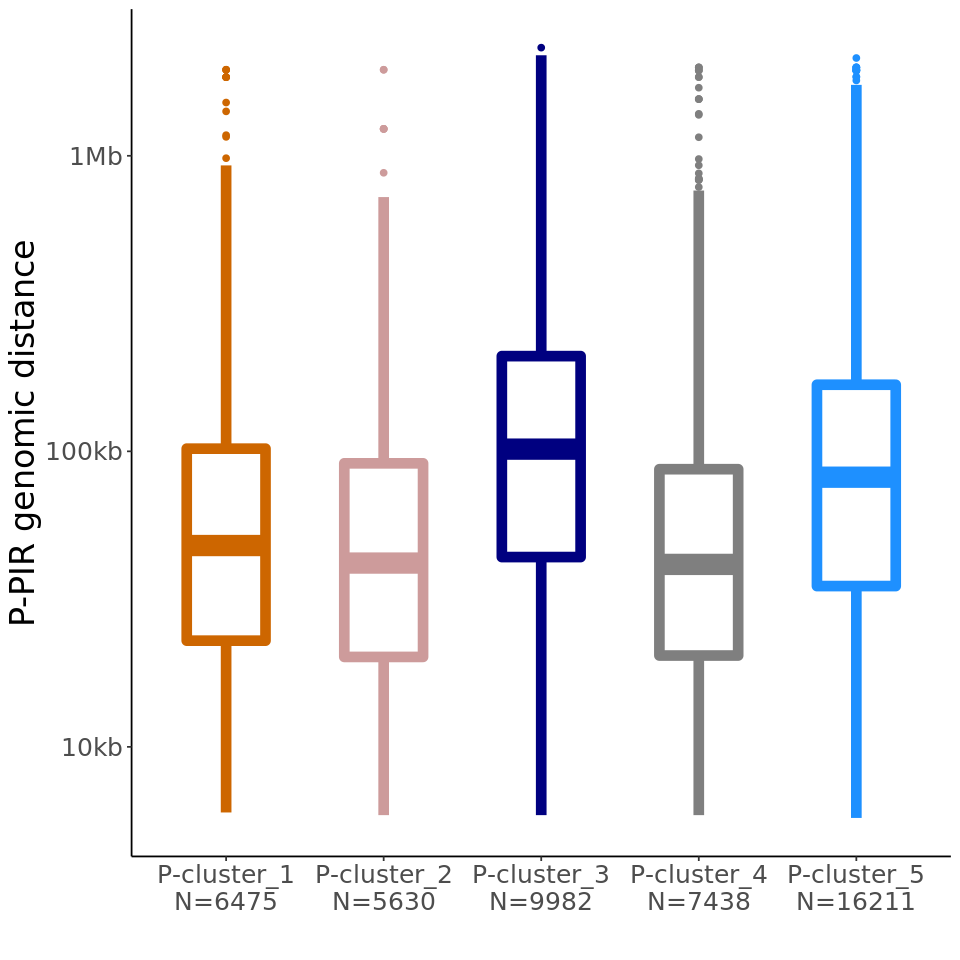

In [390]:
# number of structural and regulatory loops and their average length
loops <-read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
loops$distance <- abs((loops$V2+loops$V3)/2 - (loops$V5+loops$V6)/2)
OE_ranges <-  GRanges(seqnames = loops$V4, ranges=IRanges(start=loops$V5, end=loops$V6, enh_id = seq(1,nrow(loops))))
structural_PIRs <- filter(DNase, cluster==3 | cluster ==5)[,1:3]
structural_ranges <- GRanges(seqnames = structural_PIRs$DNase_chr, ranges=IRanges(start=structural_PIRs$DNase_start, end=structural_PIRs$DNase_end, enh_id = seq(1,nrow(structural_PIRs))))
regulatory_PIRs <- filter(DNase, cluster==1)[,1:3]
regulatory_ranges <- GRanges(seqnames = regulatory_PIRs$DNase_chr, ranges=IRanges(start=regulatory_PIRs$DNase_start, end=regulatory_PIRs$DNase_end, enh_id = seq(1,nrow(regulatory_PIRs))))
structural_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, structural_ranges))[,1]),]
regulatory_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, regulatory_ranges))[,1]),]
cat("Median span of structural loops anchored on DHSs from clusters 3 and 5 is", 
    round(median(structural_loops$distance)/1000,0),"kb,
whereas median span of regulatory loops anchored on DHSs from cluster 1 is",
    round(median(regulatory_loops$distance)/1000,0),"kb.")

# plotting loops length distribution
cl1_PIRs <- filter(DNase, cluster==1)[,1:3]
cl2_PIRs <- filter(DNase, cluster==2)[,1:3]
cl3_PIRs <- filter(DNase, cluster==3)[,1:3]
cl4_PIRs <- filter(DNase, cluster==4)[,1:3]
cl5_PIRs <- filter(DNase, cluster==5)[,1:3]
cl1_ranges <- GRanges(seqnames = cl1_PIRs$DNase_chr, ranges=IRanges(start=cl1_PIRs$DNase_start, end=cl1_PIRs$DNase_end, enh_id = seq(1,nrow(cl1_PIRs))))
cl2_ranges <- GRanges(seqnames = cl2_PIRs$DNase_chr, ranges=IRanges(start=cl2_PIRs$DNase_start, end=cl2_PIRs$DNase_end, enh_id = seq(1,nrow(cl2_PIRs))))
cl3_ranges <- GRanges(seqnames = cl3_PIRs$DNase_chr, ranges=IRanges(start=cl3_PIRs$DNase_start, end=cl3_PIRs$DNase_end, enh_id = seq(1,nrow(cl3_PIRs))))
cl4_ranges <- GRanges(seqnames = cl4_PIRs$DNase_chr, ranges=IRanges(start=cl4_PIRs$DNase_start, end=cl4_PIRs$DNase_end, enh_id = seq(1,nrow(cl4_PIRs))))
cl5_ranges <- GRanges(seqnames = cl5_PIRs$DNase_chr, ranges=IRanges(start=cl5_PIRs$DNase_start, end=cl5_PIRs$DNase_end, enh_id = seq(1,nrow(cl5_PIRs))))
cl1_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, cl1_ranges))[,1]),]
cl2_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, cl2_ranges))[,1]),]
cl3_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, cl3_ranges))[,1]),]
cl4_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, cl4_ranges))[,1]),]
cl5_loops <- loops[unique(as.data.frame(findOverlaps(OE_ranges, cl5_ranges))[,1]),]
cl1_loops$cl <- "cl1"
cl2_loops$cl <- "cl2"
cl3_loops$cl <- "cl3"
cl4_loops$cl <- "cl4"
cl5_loops$cl <- "cl5"
loops <- bind_rows(cl1_loops,cl2_loops,cl3_loops,cl4_loops,cl5_loops)
labels <- c(paste0("P-cluster_1\nN=",nrow(cl1_loops)),paste0("P-cluster_2\nN=",nrow(cl2_loops)),
            paste0("P-cluster_3\nN=",nrow(cl3_loops)),paste0("P-cluster_4\nN=",nrow(cl4_loops)),
            paste0("P-cluster_5\nN=",nrow(cl5_loops)))
options(repr.plot.width=8, repr.plot.height=8)
ggplot(loops) + theme_classic()+
   geom_boxplot(aes(cl,log10(distance)),width=0.5, lwd=3,
             color=c("darkorange3","rosybrown3","navyblue","grey50","dodgerblue")) +
   xlab("")+ylab("P-PIR genomic distance")+
   scale_x_discrete(labels=labels)+scale_y_continuous(breaks=c(4,5,6),labels=c("10kb","100kb","1Mb"))+
   theme(axis.text=element_text(size=15),axis.title=element_text(size=20))

# Building random-forest models predicting strength of MChIP-C signal

## Selecting P-DHS pairs and collecting feature signals for model

In [36]:
rm(list=ls())
baits <- read.csv("MChIPC_output/MChIPC_viewpoints.bed", header = F, sep = "\t")
baits <- filter(baits,V5>1000)[,1:3]
colnames(baits) <- c("bait_chr","bait_start","bait_end")
DNase <- read.csv("Auxiliary_data/peaks/ENCFF621ZJY.bed.gz", header = F, sep = "\t")
DNase <-filter(DNase, V7>200)

In [37]:
H3K4me3_mask <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/H3K4me3.mask.bed", header = F, sep = "\t")
H3K4me3_ranges <- GRanges(seqnames = H3K4me3_mask$V1, ranges=IRanges(start=H3K4me3_mask$V2-5000, end=H3K4me3_mask$V3+5000, enh_id = seq(1,nrow(H3K4me3_mask))))
DNase_ranges <- GRanges(seqnames = DNase$V1, ranges=IRanges(start=DNase$V2, end=DNase$V3, enh_id = seq(1,nrow(DNase))))
DNase <- DNase[-as.data.frame(findOverlaps(DNase_ranges,H3K4me3_ranges))[,1],]
write.table(DNase[,1:3], "tmp/DNase_for_forest.bed", quote = F, col.names = F, row.names = F, sep = "\t")
bait_ranges <- GRanges(seqnames = baits$bait_chr, ranges=IRanges(start=baits$bait_start, end=baits$bait_end, enh_id = seq(1,nrow(baits))))
bait_left_ranges <- GRanges(seqnames = baits$bait_chr, ranges=IRanges(start=baits$bait_start-250000, end=baits$bait_start-5000, enh_id = seq(1,nrow(baits))))
bait_right_ranges <- GRanges(seqnames = baits$bait_chr, ranges=IRanges(start=baits$bait_end+5000, end=baits$bait_end+250000, enh_id = seq(1,nrow(baits))))
DNase_ranges <- GRanges(seqnames = DNase$V1, ranges=IRanges(start=DNase$V2, end=DNase$V3, enh_id = seq(1,nrow(DNase))))
left_overlaps <- countOverlaps(DNase_ranges, bait_left_ranges)
right_overlaps <- countOverlaps(DNase_ranges, bait_right_ranges)
DNase$V4 <- left_overlaps+right_overlaps
DNase <- filter(DNase, V4>0)
DNase_ranges <- GRanges(seqnames = DNase$V1, ranges=IRanges(start=DNase$V2, end=DNase$V3, enh_id = seq(1,nrow(DNase))))
contacts <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")

In [38]:
contacts <- contacts[,c(1:6,11,21,28)]
contacts <- filter(contacts, dist_rank <= 1000)

In [39]:
loops <- data_frame()
# this may take some time
for (i in seq(1,nrow(DNase))){
  site <- DNase[i,]
  contact_site <- filter(contacts, vp_chr==site$V1 & OE_start < site$V3 & OE_end > site$V2)
  if (nrow(contact_site)>0){
     contact_site$site_id <- i  
     loops <- rbind(loops,contact_site)}
  else {}
  if ((i%%10000)==0){
      message(paste0("processed ",i," DNase sites out of ", nrow(DNase)))
  }
  #message(paste0("processed ",i," i"))
}

processed 10000 DNase sites out of 32861

processed 20000 DNase sites out of 32861

processed 30000 DNase sites out of 32861



In [40]:
loops <- loops %>% group_by(vp_chr,vp_start,vp_end,site_id) %>% summarise(N_sum_double_norm = max(N_sum_double_norm)) %>% arrange(site_id)
DNase$site_id <- seq(1,nrow(DNase))
loops <- left_join(loops, DNase, by=c("site_id"))
loops$distance <- (loops$V2+loops$V3)/2 - (loops$vp_start+loops$vp_end)/2
loops <- loops[,c(1,2,3,6,7,8,5,16)]
# looking for sites overlapping CTCF peaks:
CTCF_peaks <- read.csv("Auxiliary_data/peaks/ENCFF002CEL.bed.gz", header = F, sep = "\t")
CTCF_ranges <- GRanges(seqnames = CTCF_peaks$V1, ranges=IRanges(start=CTCF_peaks$V2, end=CTCF_peaks$V3))
baits_wCTCF <- baits[(unique(as.data.frame(findOverlaps(bait_ranges, CTCF_ranges))[,1])),]
DNase_wCTCF <- DNase[(unique(as.data.frame(findOverlaps(DNase_ranges, CTCF_ranges))[,1])),]
write.table(baits_wCTCF[,1:3], "tmp/baits_wCTCF.txt", quote = F, col.names = F, row.names = F, sep = "\t")
write.table(DNase_wCTCF[,1:3], "tmp/DNase_wCTCF.txt", quote = F, col.names = F, row.names = F, sep = "\t")
mot <- system("conda info | grep 'active env location' | cut -d ':' -f 2", intern=T)
mot <- substr(mot, 2, nchar(mot))
mot <- paste0(mot,"/share/homer/motifs/ctcf.motif")
system(paste0("annotatePeaks.pl tmp/DNase_wCTCF.txt hg19 -nogene -noann -m ", mot," > tmp/motifs_in_DNase"), 
       intern=T)
system(paste0("annotatePeaks.pl tmp/baits_wCTCF.txt hg19 -nogene -noann -m ", mot," > tmp/motifs_in_baits"), 
       intern=T)
baits_wCTCF <- read.csv("tmp/motifs_in_baits", header = T, sep = "\t")
colnames(baits_wCTCF)[10] <- "V10"
baits_wCTCF$baits_CTCF_minus <- grepl("\\-",baits_wCTCF$V10)
baits_wCTCF$baits_CTCF_plus <- grepl("\\+",baits_wCTCF$V10)
baits_wCTCF <- baits_wCTCF[,c(2:4,11,12)]
DNase_wCTCF <- read.csv("tmp/motifs_in_DNase", header = T, sep = "\t")
colnames(DNase_wCTCF)[10] <- "V10"
DNase_wCTCF$DNase_CTCF_minus <- grepl("\\-",DNase_wCTCF$V10)
DNase_wCTCF$DNase_CTCF_plus <- grepl("\\+",DNase_wCTCF$V10)
DNase_wCTCF <- DNase_wCTCF[,c(2:4,11,12)]
loops[is.na(loops)] <- 0
colnames(baits_wCTCF)[1:3]<- colnames(loops)[1:3]
colnames(DNase_wCTCF)[1:3]<- colnames(loops)[4:6]
loops <- left_join(loops, baits_wCTCF[,c(1,3:5)])
loops <- left_join(loops, DNase_wCTCF[,c(1,3:5)])
loops[is.na(loops)] <- FALSE
system(paste0("multiBigwigSummary BED-file -b Auxiliary_data/bigwigs/ENCFF000BWF.bigWig --outRawCounts tmp/baits_CTCF_coverage.txt --BED MChIPC_output/mononucleosomal_and_ChIP/binned_peaks.bed -o tmp/results.npz"))
bait_CTCF_coverage <- read.csv("tmp/baits_CTCF_coverage.txt", header = T, sep = "\t")
colnames(bait_CTCF_coverage)[1:3] <- colnames(loops)[1:3]
colnames(bait_CTCF_coverage)[4] <-"bait_CTCF_coverage"
loops <- left_join(loops, bait_CTCF_coverage)
loops$bait_CTCF_coverage[is.na(loops$bait_CTCF_coverage)] <-0

`summarise()` has grouped output by 'vp_chr', 'vp_start', 'vp_end'. You can
override using the `.groups` argument.


character(0)

character(0)

Joining, by = c("vp_chr", "vp_end")
Joining, by = c("V1", "V3")
Joining, by = c("vp_chr", "vp_start", "vp_end")


In [42]:
# estimating the ChIP-seq signal of 271 analyzed TRF over DNase sites
# it may take some time
system("files=$(cut Auxiliary_data/list_of_files.txt -f 3);
        path='Auxiliary_data/bigwigs/';
        for file in $files; do list=$(echo $list $path$file); done;
        multiBigwigSummary BED-file -b $list -o tmp/results.npz --outRawCounts tmp/ChIP_signal.txt -p 8 --BED tmp/DNase_for_forest.bed", intern=T)

character(0)

In [44]:
list_of_files <- read.csv("Auxiliary_data/list_of_files.txt", header=F, sep = "\t")
list_of_files <- separate(list_of_files, V3, sep="\\.", into = c("features",NA))

In [116]:
ChIP_data <- read.csv("tmp/ChIP_signal.txt", header = T, sep = "\t")
ChIP_data[is.na(ChIP_data)] <- 0
colnames(ChIP_data)[1:3] <- colnames(loops)[4:6]
colnames(ChIP_data)[4:length(colnames(ChIP_data))]<-lapply(strsplit(colnames(ChIP_data)[4:length(colnames(ChIP_data))], "\\."), function(i) i[2])

In [117]:
for (i in seq(4,length(colnames(ChIP_data)))){
    colnames(ChIP_data)[i]<-filter(list_of_files, features==colnames(ChIP_data)[i])[1,1]
}

In [119]:
loops <- left_join(loops, ChIP_data)
colnames(loops)[4:7] <- c("DNase_chr","DNase_start","DNase_end", "interaction_score")
loops$relative_posit <- loops$distance > 0
loops$distance <- abs(loops$distance)
write.table(loops, "Summary_output_datasets/data_for_random_forest.txt", 
            quote = F, col.names = T, row.names = F, sep = "\t")

Joining, by = c("V1", "V2", "V3")


## Stepwise feature selection

In [2]:
rm(list=ls())
loops <- read.csv("Summary_output_datasets/data_for_random_forest.txt", header = T, sep = "\t")
# filtering out two clear outliers
loops1 <- filter(loops, !(interaction_score %in% sort(loops$interaction_score, decreasing = TRUE)[c(1,2)]))
cat("Eventually we are using",nrow(loops1), "P-DHS pairs to build our models.")

Eventually we are using 107213 P-DHS pairs to build our models.

In [3]:
set.seed(1)
# building distance-only model
cols <- grep(TRUE, colnames(loops1) %in% c("interaction_score","distance"))
data_for_model <- loops1[,cols]
ind <- sample(3, nrow(data_for_model), replace = TRUE, prob = c(0.33, 0.33, 0.33))
test_1 <- data_for_model[ind==1,]
test_2 <- data_for_model[ind==2,]
test_3 <- data_for_model[ind==3,]
model_1 <- ranger(interaction_score~., data=bind_rows(test_2, test_3), num.trees=100, mtry = 1)
model_2 <- ranger(interaction_score~., data=bind_rows(test_1, test_3), num.trees=100, mtry = 1)
model_3 <- ranger(interaction_score~., data=bind_rows(test_1, test_2), num.trees=100, mtry = 1)
rsq_distance <- c((cor(predict(model_1, test_1)$predictions, test_1$interaction_score))^2,
                  (cor(predict(model_2, test_2)$predictions, test_2$interaction_score))^2,
                  (cor(predict(model_3, test_3)$predictions, test_3$interaction_score))^2)

In [4]:
set.seed(1)
# building basic model which includes distance, CTCF binding and CTCF motif orientation on both promoter and DHS
cols <- grep(TRUE, colnames(loops1) %in% c("interaction_score","distance","baits_CTCF_minus","baits_CTCF_plus",
"DNase_CTCF_minus","DNase_CTCF_plus","bait_CTCF_coverage","CTCF","relative_posit"),value=FALSE)
data_for_model <- loops1[,cols]
ind <- sample(3, nrow(data_for_model), replace = TRUE, prob = c(0.33, 0.33, 0.33))
test_1 <- data_for_model[ind==1,]
test_2 <- data_for_model[ind==2,]
test_3 <- data_for_model[ind==3,]
model_1 <- ranger(interaction_score~., data=bind_rows(test_2, test_3), num.trees=100, mtry = 3)
model_2 <- ranger(interaction_score~., data=bind_rows(test_1, test_3), num.trees=100, mtry = 3)
model_3 <- ranger(interaction_score~., data=bind_rows(test_1, test_2), num.trees=100, mtry = 3)
rsq_initial <- c((cor(predict(model_1, test_1)$predictions, test_1$interaction_score))^2,
                 (cor(predict(model_2, test_2)$predictions, test_2$interaction_score))^2,
                 (cor(predict(model_3, test_3)$predictions, test_3$interaction_score))^2)

In [5]:
set.seed(1)
# stepwise (10 steps) addition of features to the basic model
cols <- grep(TRUE, colnames(loops1) %in% c("interaction_score","distance","baits_CTCF_minus","baits_CTCF_plus",
"DNase_CTCF_minus","DNase_CTCF_plus","bait_CTCF_coverage","CTCF","relative_posit"),value=FALSE)
data_for_model <- loops1[,cols]
features <- colnames(loops1)[14:length(colnames(loops1))]
neg <- grep(TRUE, features %in% c("CTCF","relative_posit"),value=FALSE)
features <- features[-neg]
all_models <- tibble(features=features)
step <- tibble(features=features)
selected <- c()
rsquared <- c()
for (a in 1:10){
  message(paste0("starting step ",a," of forward feature selection"))
  step$rsquared <- 0
  step$r1 <- 0
  step$r2 <- 0
  step$r3 <- 0
  for (i in features){
     data_for_model[i] <- loops1[i]
     ind <- sample(3, nrow(data_for_model), replace = TRUE, prob = c(0.33, 0.33, 0.33))
     test_1 <- data_for_model[ind==1,]
     test_2 <- data_for_model[ind==2,]
     test_3 <- data_for_model[ind==3,]
     model_1 <- ranger(interaction_score~., data=bind_rows(test_2, test_3), num.trees=100, mtry = 3)
     model_2 <- ranger(interaction_score~., data=bind_rows(test_1, test_3), num.trees=100, mtry = 3)
     model_3 <- ranger(interaction_score~., data=bind_rows(test_1, test_2), num.trees=100, mtry = 3)
     step$r1[step$features == i] <- (cor(predict(model_1, test_1)$predictions, test_1$interaction_score))^2
     step$r2[step$features == i] <- (cor(predict(model_2, test_2)$predictions, test_2$interaction_score))^2
     step$r3[step$features == i] <- (cor(predict(model_3, test_3)$predictions, test_3$interaction_score))^2
     step$rsquared[step$features == i] <- mean(c(step$r1[step$features == i], step$r2[step$features == i], 
                                                 step$r3[step$features == i]))
     data_for_model[i] <- NULL}
  all_models <- left_join(all_models, step[,1:2], by="features")
  step <- arrange(step, desc(rsquared))
  rsquared <- append(rsquared,  c(step$r1[1], step$r2[1],step$r3[1]))
  data_for_model[step$features[1]] <- loops1[step$features[1]]
  message("   ",step$features[1]," signal was selected at step ",a)
  selected <- append(selected, step$features[1])
  features <- setdiff(features, step$features[1])}
rsquared <- c(rsq_distance,rsq_initial,rsquared)

starting step 1 of forward feature selection

   RAD21 signal was selected at step 1

starting step 2 of forward feature selection

   EP300 signal was selected at step 2

starting step 3 of forward feature selection

   BRCA1 signal was selected at step 3

starting step 4 of forward feature selection

   ASH1L signal was selected at step 4

starting step 5 of forward feature selection

   TBL1XR1 signal was selected at step 5

starting step 6 of forward feature selection

   RBBP5 signal was selected at step 6

starting step 7 of forward feature selection

   SMARCC2 signal was selected at step 7

starting step 8 of forward feature selection

   GTF3C2 signal was selected at step 8

starting step 9 of forward feature selection

   SMAD5 signal was selected at step 9

starting step 10 of forward feature selection

   BRD4 signal was selected at step 10



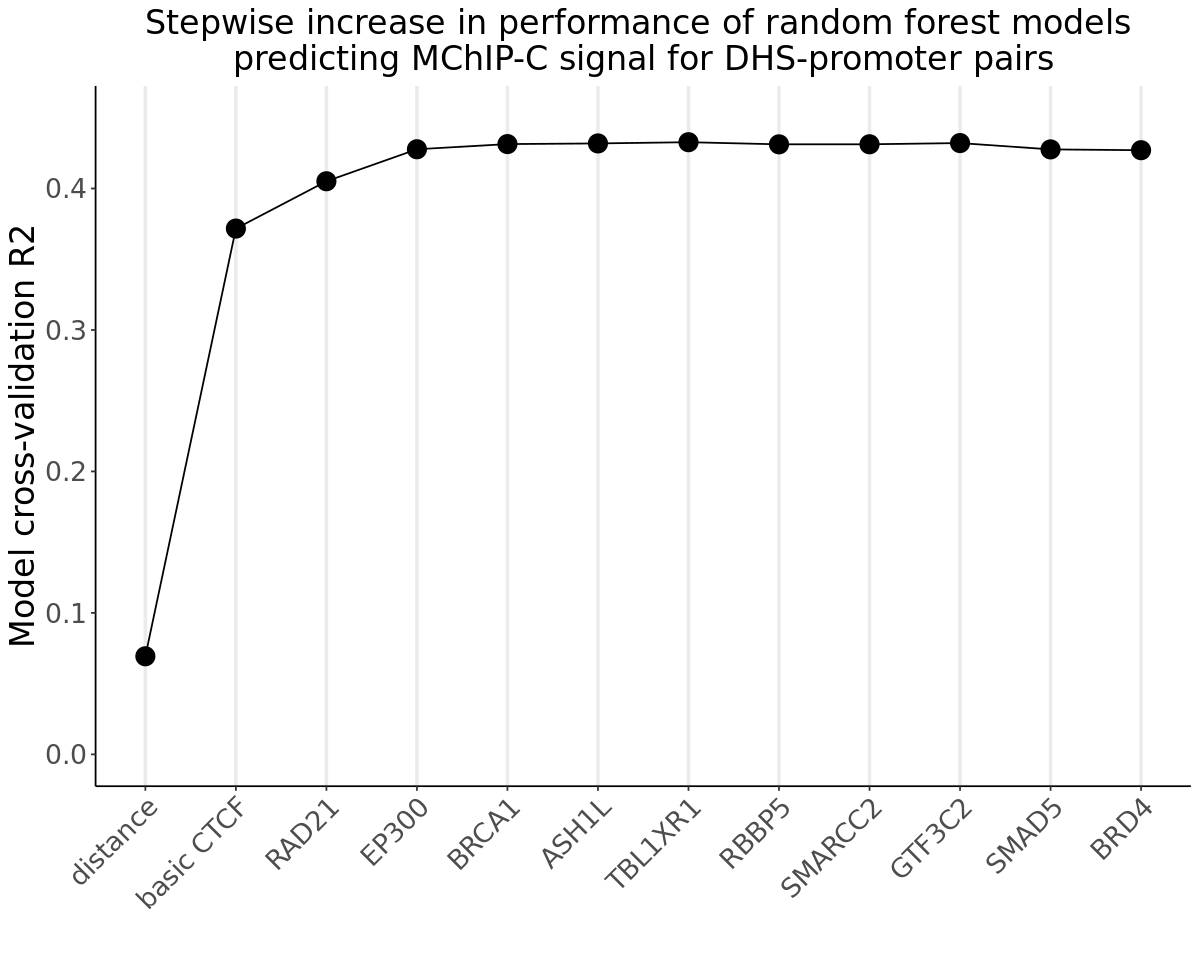

In [35]:
labels=append(c("distance","basic CTCF"),selected)
rsq <- tibble(value=as.numeric(rsquared), step = sort(rep(seq(-1,10,1), 3)))
rsq <- group_by(rsq, step) %>% summarise(R_sq=mean(value))
# change title
options(repr.plot.width=10, repr.plot.height=8)
ggplot(rsq) + geom_point(aes(step, R_sq), size=5) + ylim(0,0.45) + geom_line(aes(step, R_sq))+theme_classic()+
scale_x_continuous(breaks=seq(-1,10),labels=labels) + xlab("") + ylab("Model cross-validation R2") + 
theme(panel.grid.major.x=element_line(size=1), plot.title=element_text(size=20,hjust=0.5), axis.text=element_text(size=16),
      axis.text.x=element_text(angle=45, hjust=1),axis.title=element_text(size=20))+
ggtitle("Stepwise increase in performance of random forest models 
predicting MChIP-C signal for DHS-promoter pairs")

## In-depth analysis of step 2 of feature selection

In [7]:
set.seed(1)
loops <- read.csv("Summary_output_datasets/data_for_random_forest.txt", header = T, sep = "\t")
loops1 <- filter(loops, !(interaction_score %in% sort(loops$interaction_score, decreasing = TRUE)[c(1,2)]))
cols <- grep(TRUE, colnames(loops1) %in% c("interaction_score","distance","baits_CTCF_minus","baits_CTCF_plus",
"DNase_CTCF_minus","DNase_CTCF_plus","bait_CTCF_coverage","CTCF","RAD21","relative_posit"),value=FALSE)
data_for_model <- loops1[,cols]
features <- colnames(loops1)[14:length(colnames(loops1))]
neg <- grep(TRUE, features %in% c("CTCF","RAD21","relative_posit"),value=FALSE)
features <- features[-neg]
all_models <- tibble(features=features)
step <- tibble(features=features)
for (a in 1:1){
  step$rsquared <- 0
  step$r1 <- 0
  step$r2 <- 0
  step$r3 <- 0
  for (i in features){
    data_for_model[i] <- loops1[i]
    ind <- sample(3, nrow(data_for_model), replace = TRUE, prob = c(0.33, 0.33, 0.33))
    test_1 <- data_for_model[ind==1,]
    test_2 <- data_for_model[ind==2,]
    test_3 <- data_for_model[ind==3,]
    model_1 <- ranger(interaction_score~., data=bind_rows(test_2, test_3), num.trees=100, mtry = 3)
    model_2 <- ranger(interaction_score~., data=bind_rows(test_1, test_3), num.trees=100, mtry = 3)
    model_3 <- ranger(interaction_score~., data=bind_rows(test_1, test_2), num.trees=100, mtry = 3)
    step$r1[step$features == i] <- (cor(predict(model_1, test_1)$predictions, test_1$interaction_score))^2
    step$r2[step$features == i] <- (cor(predict(model_2, test_2)$predictions, test_2$interaction_score))^2
    step$r3[step$features == i] <- (cor(predict(model_3, test_3)$predictions, test_3$interaction_score))^2
    step$rsquared[step$features == i] <- mean(c(step$r1[step$features == i], step$r2[step$features == i], 
                                                step$r3[step$features == i]))
    data_for_model[i] <- NULL}
  all_models <- left_join(all_models, step[,1:2], by="features")
  step <- arrange(step, desc(rsquared))}

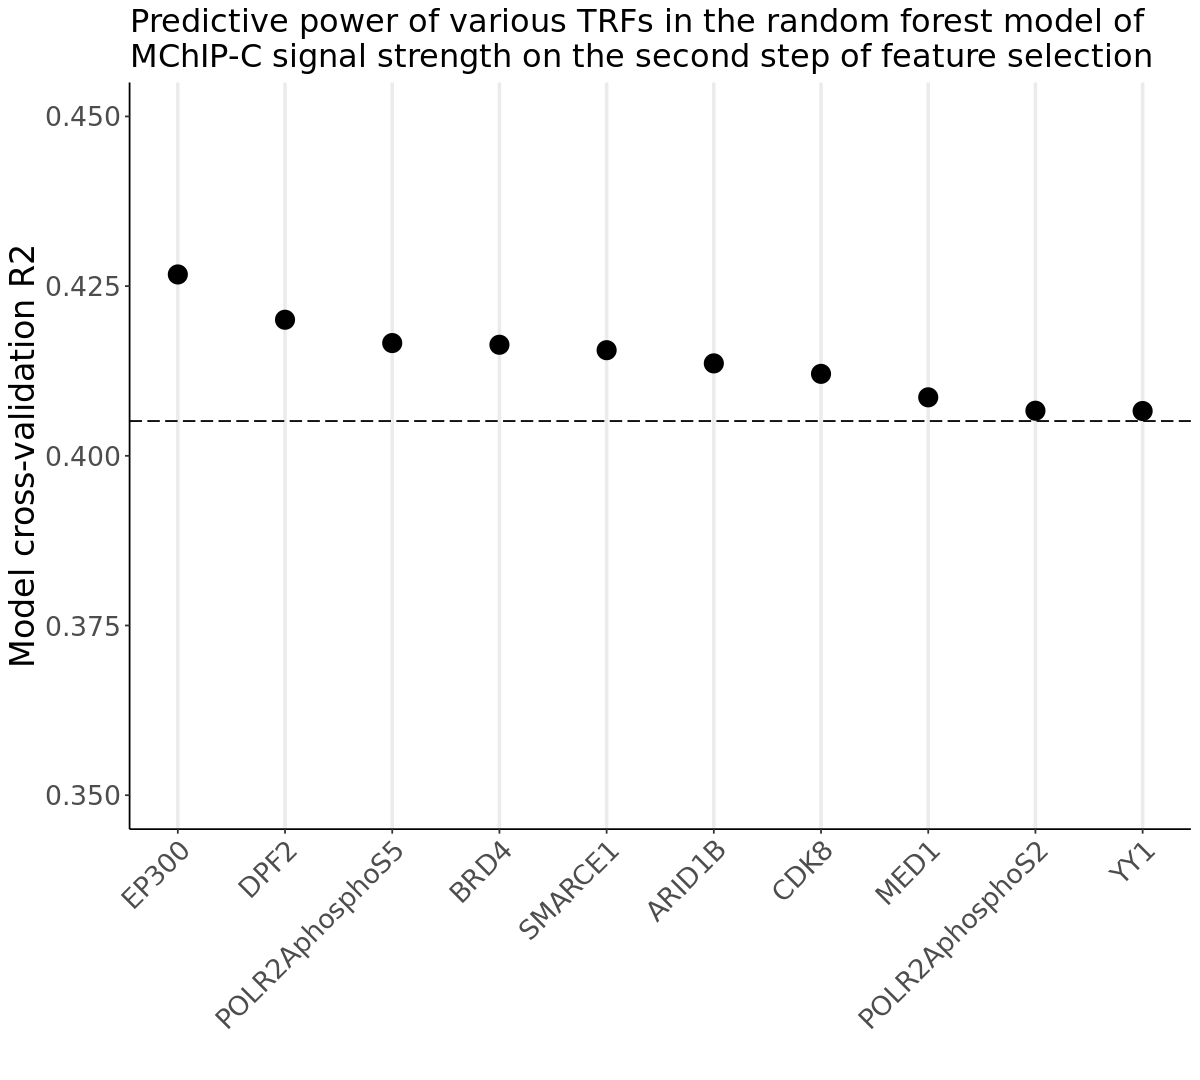

In [16]:
data_for_plot <- filter(step, features %in% c("EP300","ARID1B","DPF2", "POLR2AphosphoS5","POLR2AphosphoS2", "BRD4","CDK8","YY1","MED1","SMARCE1"))
data_for_plot <- arrange(data_for_plot,desc(rsquared))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(data_for_plot) + geom_point(aes(seq(1:10), rsquared),size=5) + ylim(0.35,0.45) +theme_classic()+
scale_x_continuous(breaks=seq(1,10),labels=data_for_plot$features) + 
geom_hline(yintercept=rsq$R_sq[3], linetype=5) + xlab("") + ylab("Model cross-validation R2") +
theme(panel.grid.major.x=element_line(size=1), title=element_text(size=16), axis.text=element_text(size=16),
      axis.text.x=element_text(angle=45, hjust=1),axis.title=element_text(size=20))+
ggtitle("Predictive power of various TRFs in the random forest model of 
MChIP-C signal strength on the second step of feature selection")